In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS
from statsforecast.arima import arima_string

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

/home/hiraeth/anaconda3/envs/smps/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use('fivethirtyeight')
# plt.rcParams['lines.linewidth'] = 1.5
# dark_style = {
#     'figure.facecolor': '#212946',
#     'axes.facecolor': '#212946',
#     'savefig.facecolor':'#212946',
#     'axes.grid': True,
#     'axes.grid.which': 'both',
#     'axes.spines.left': False,
#     'axes.spines.right': False,
#     'axes.spines.top': False,
#     'axes.spines.bottom': False,
#     'grid.color': '#2A3459',
#     'grid.linewidth': '1',
#     'text.color': '0.9',
#     'axes.labelcolor': '0.9',
#     'xtick.color': '0.9',
#     'ytick.color': '0.9',
#     'font.size': 12 
# }
# plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


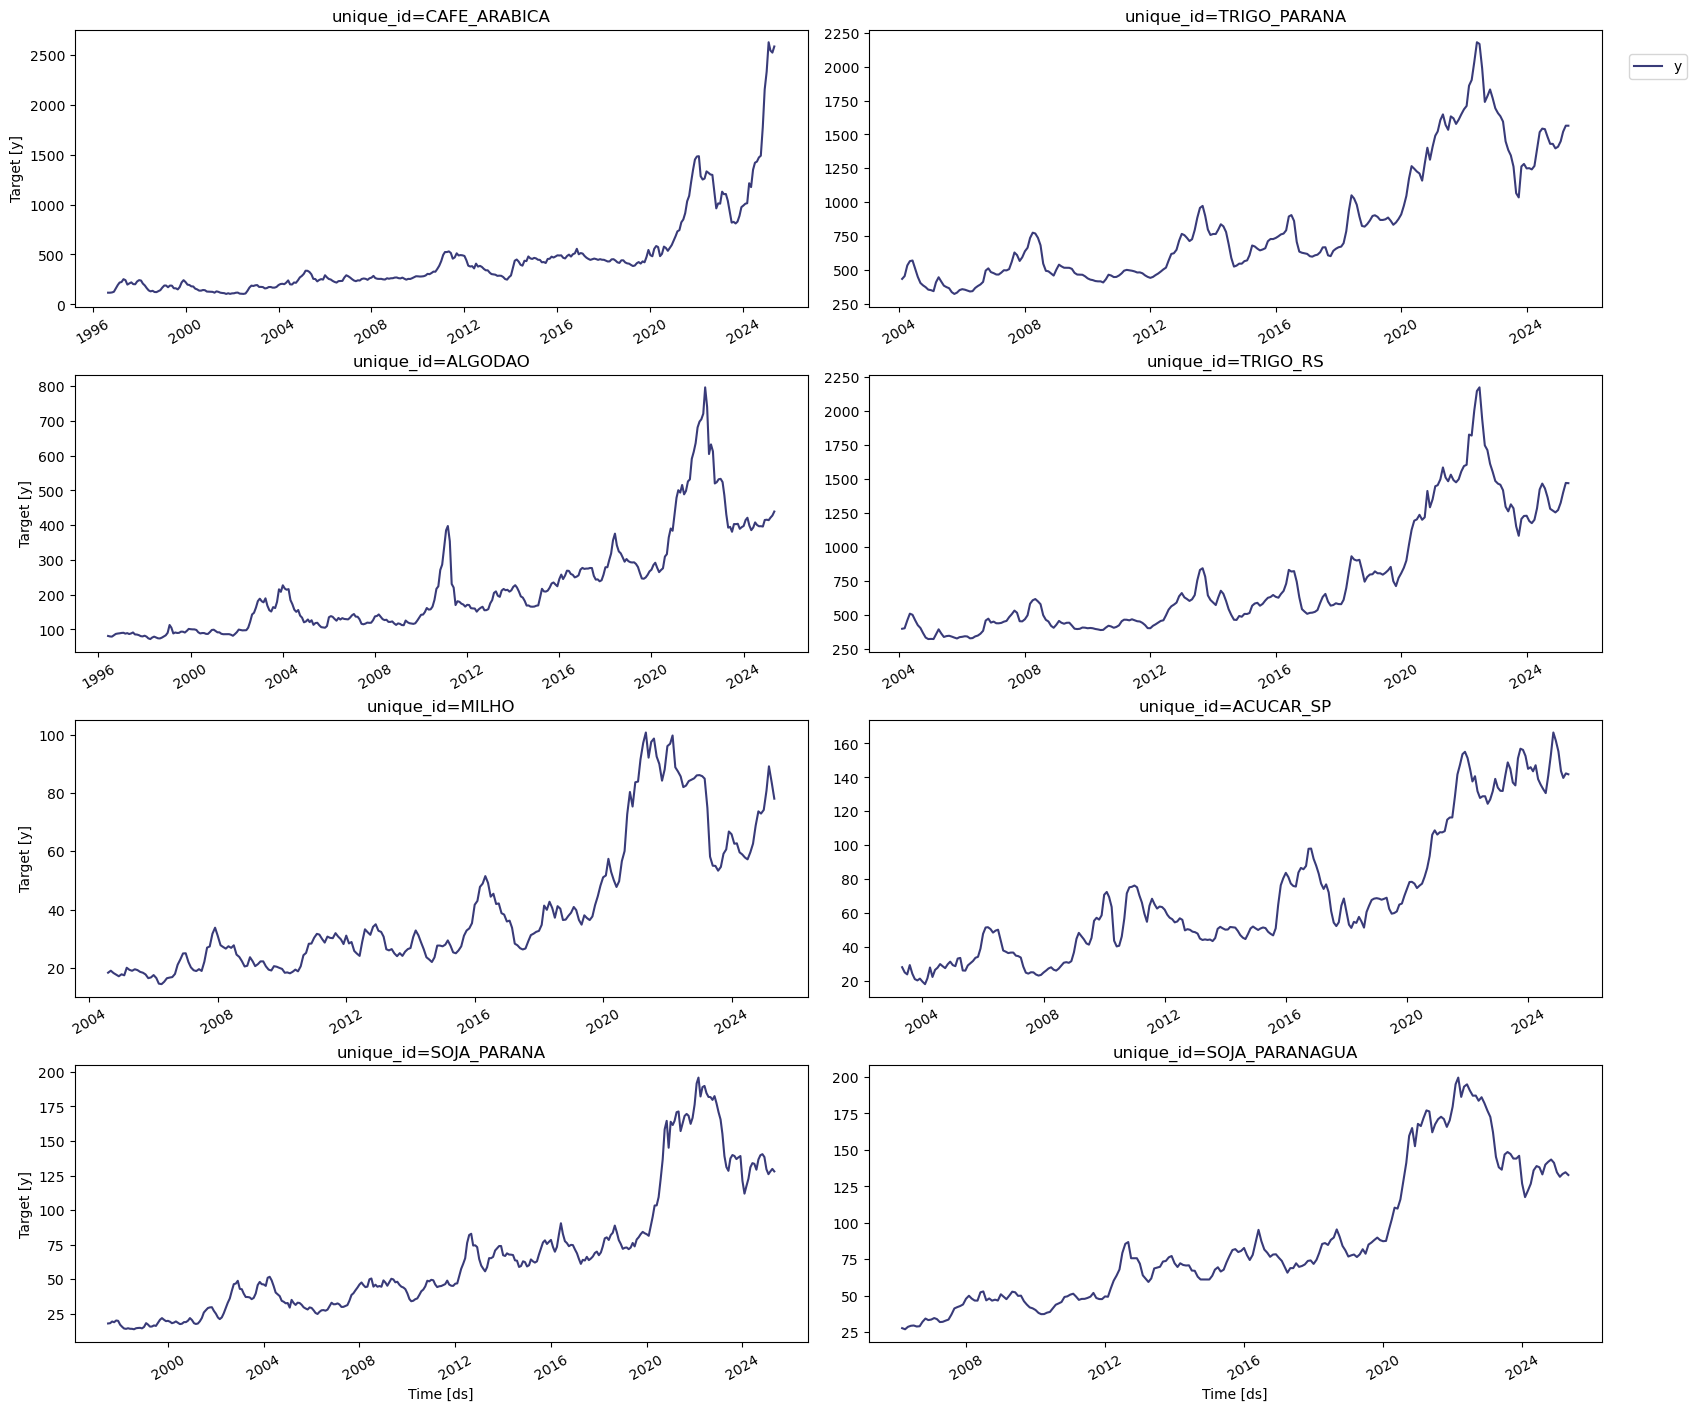

In [4]:
StatsForecast.plot(df_brl)

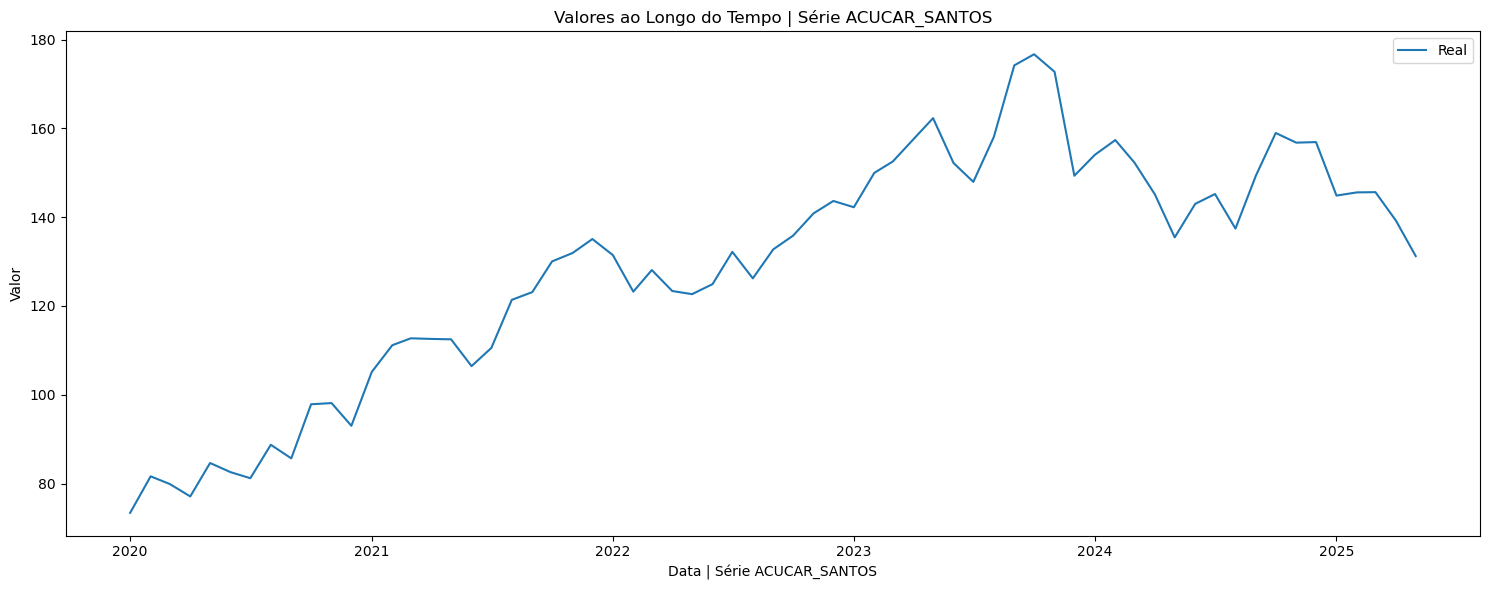

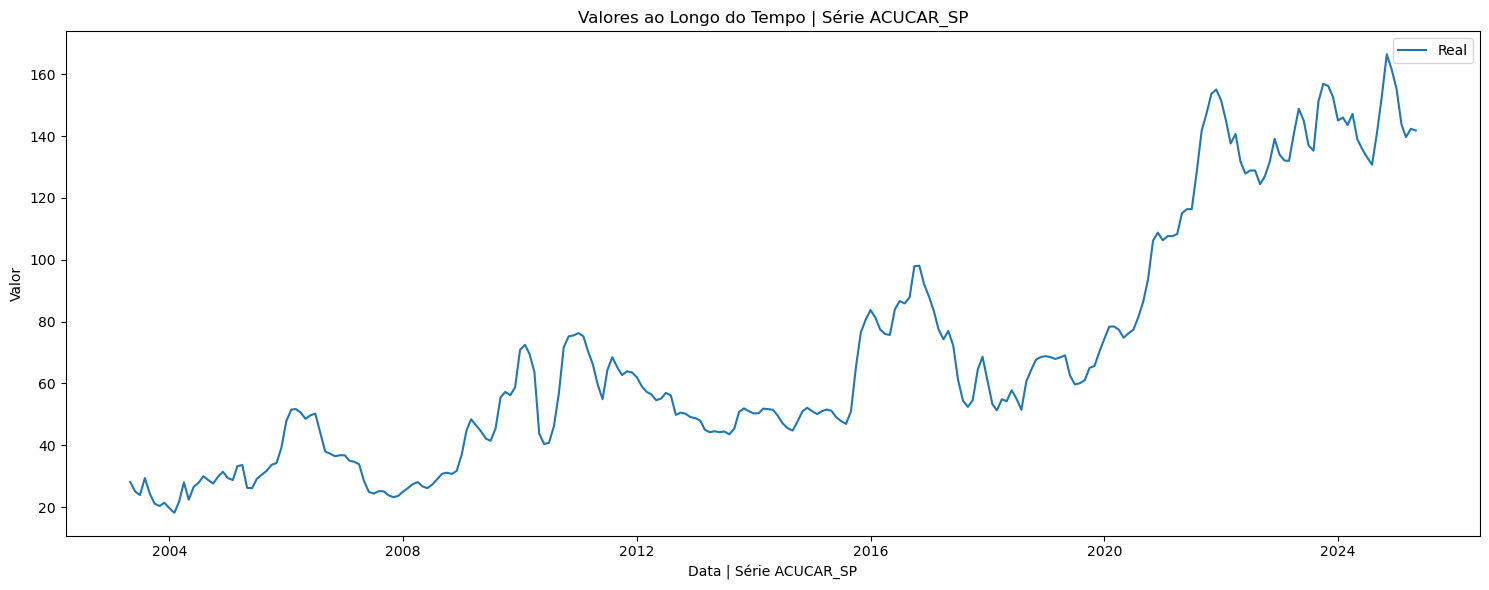

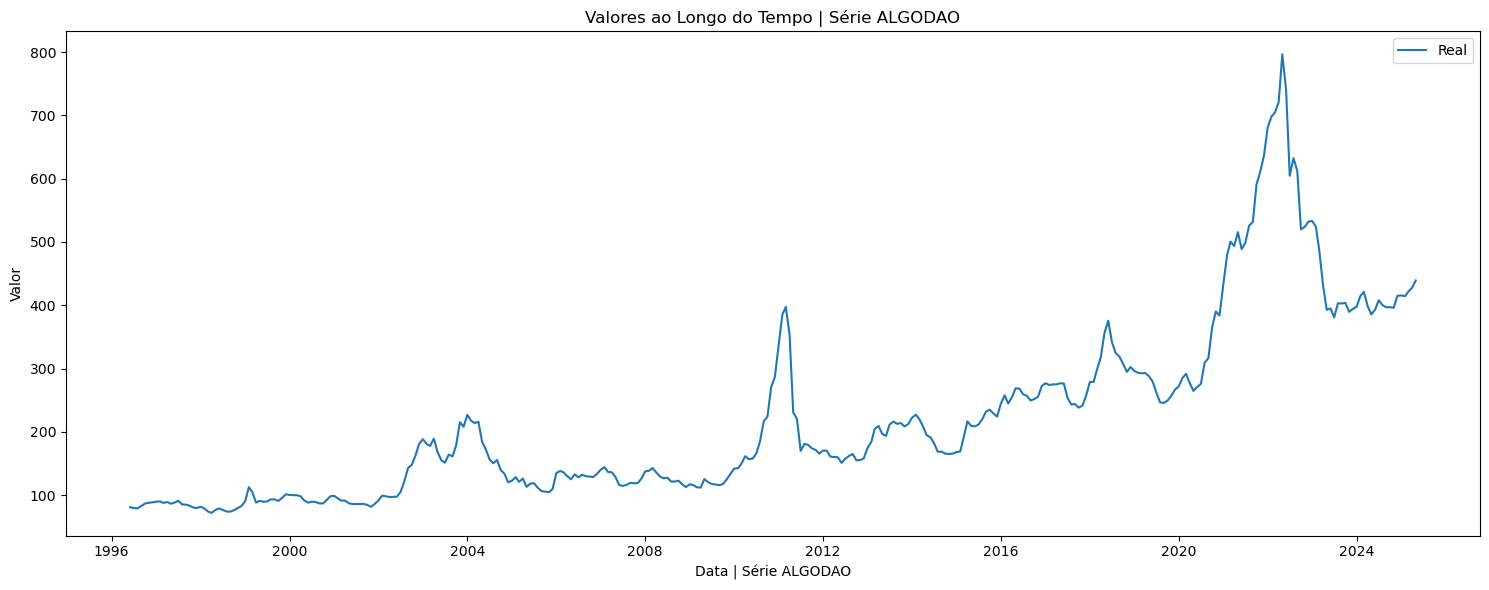

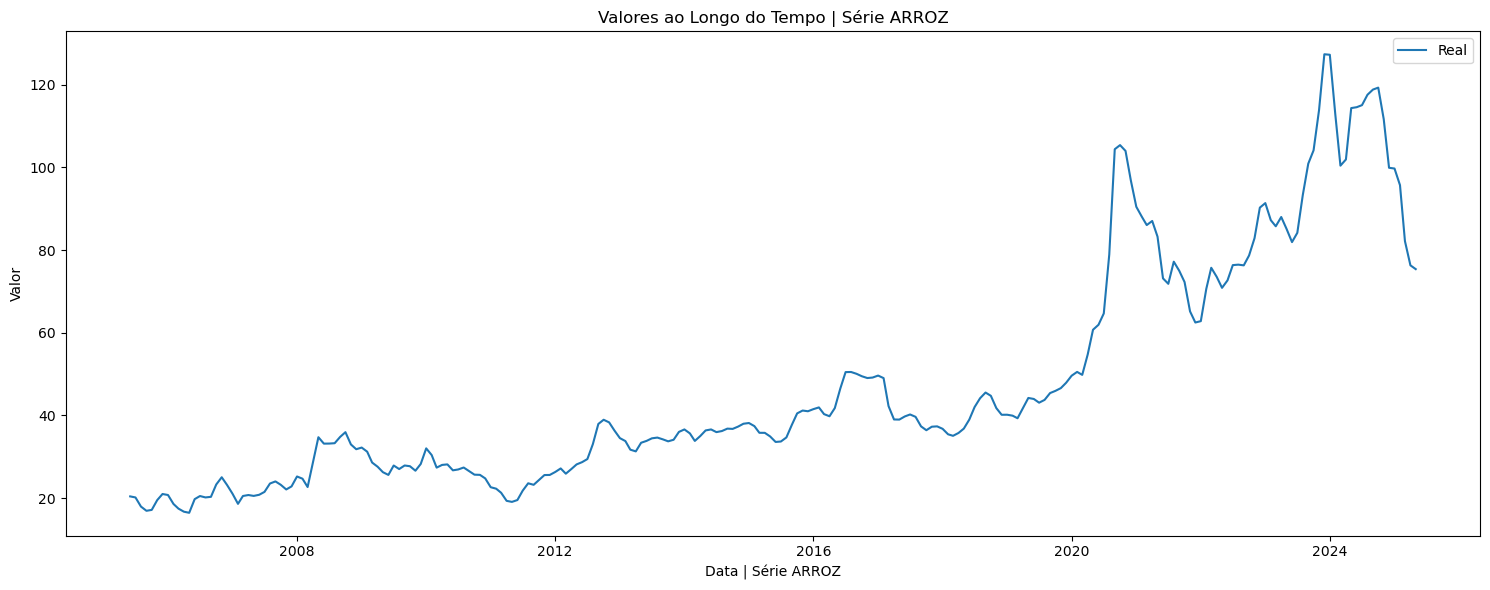

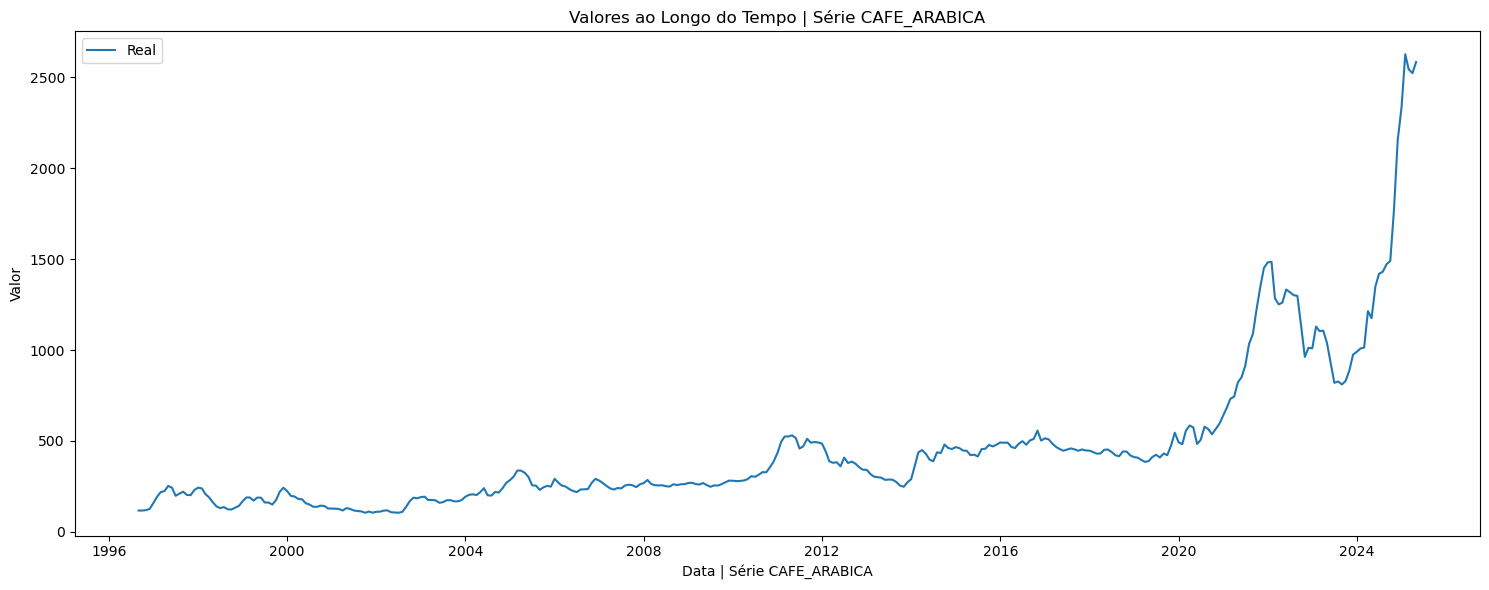

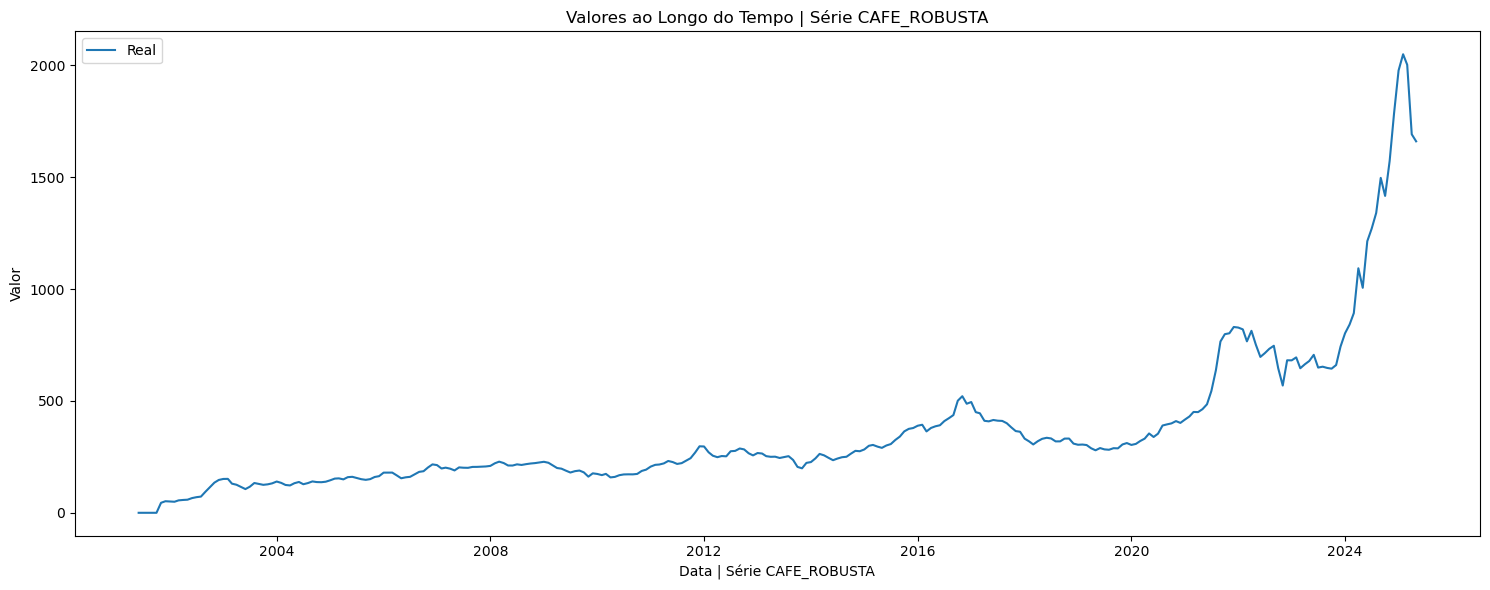

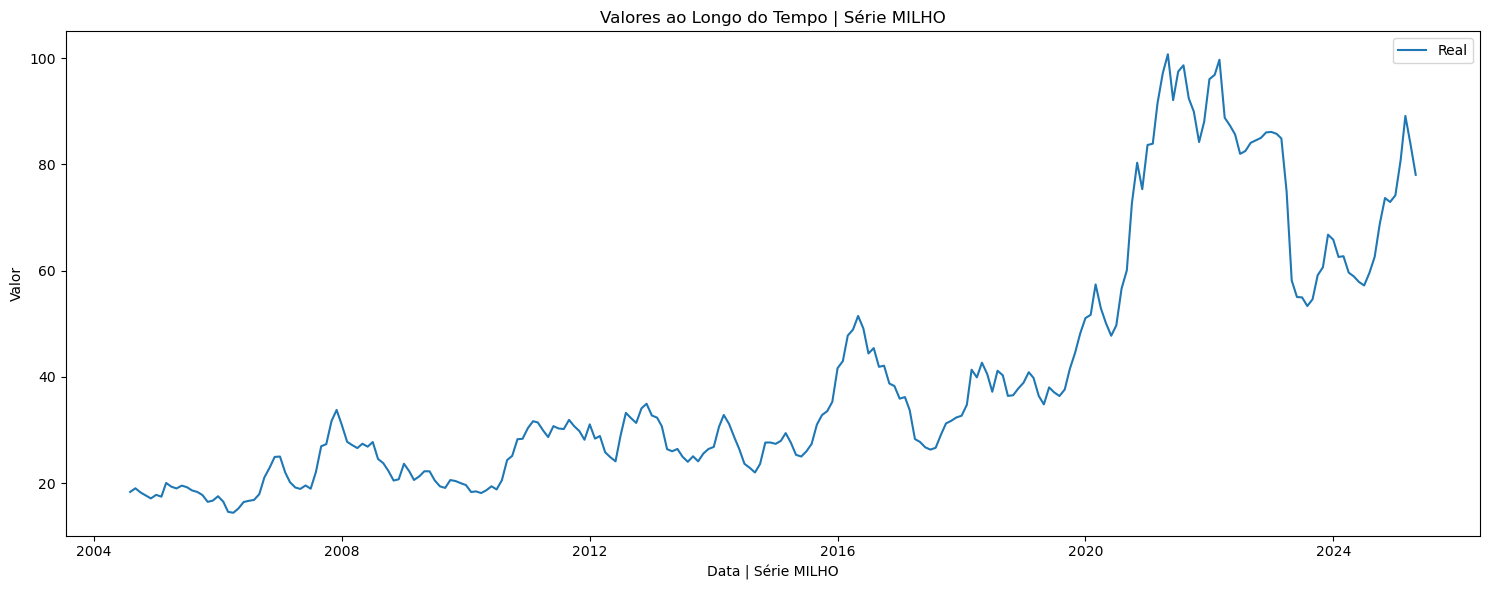

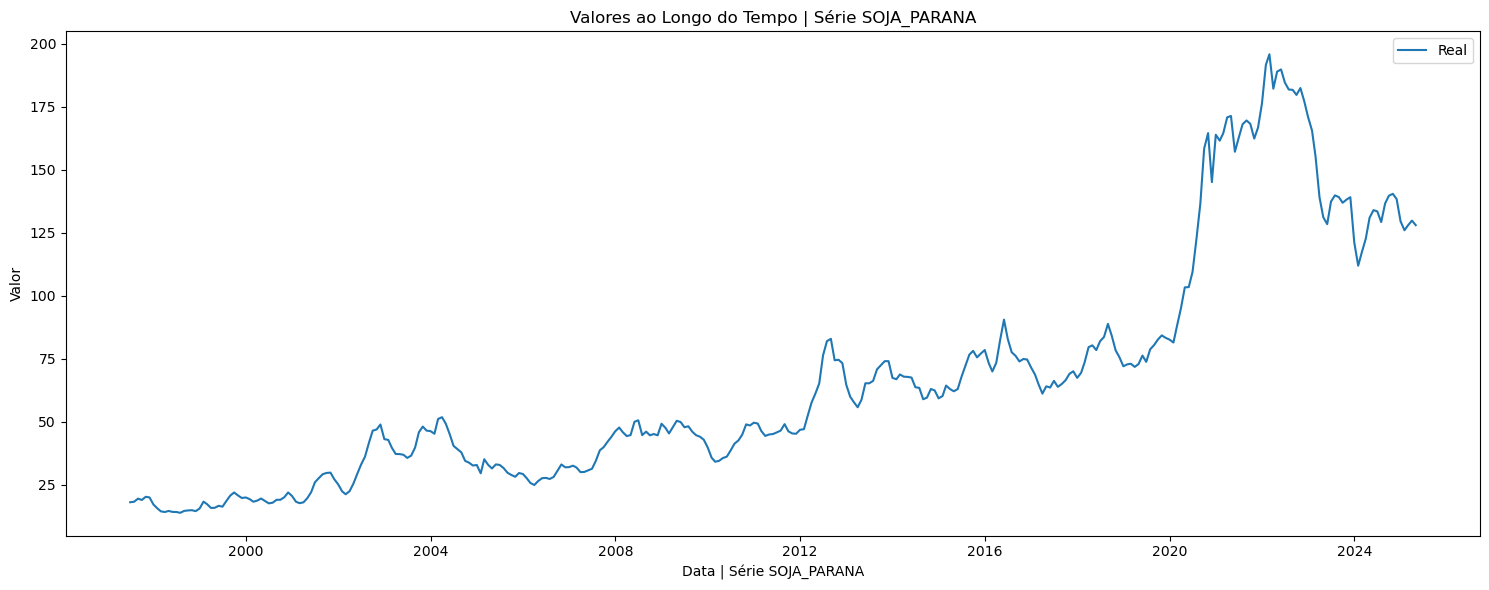

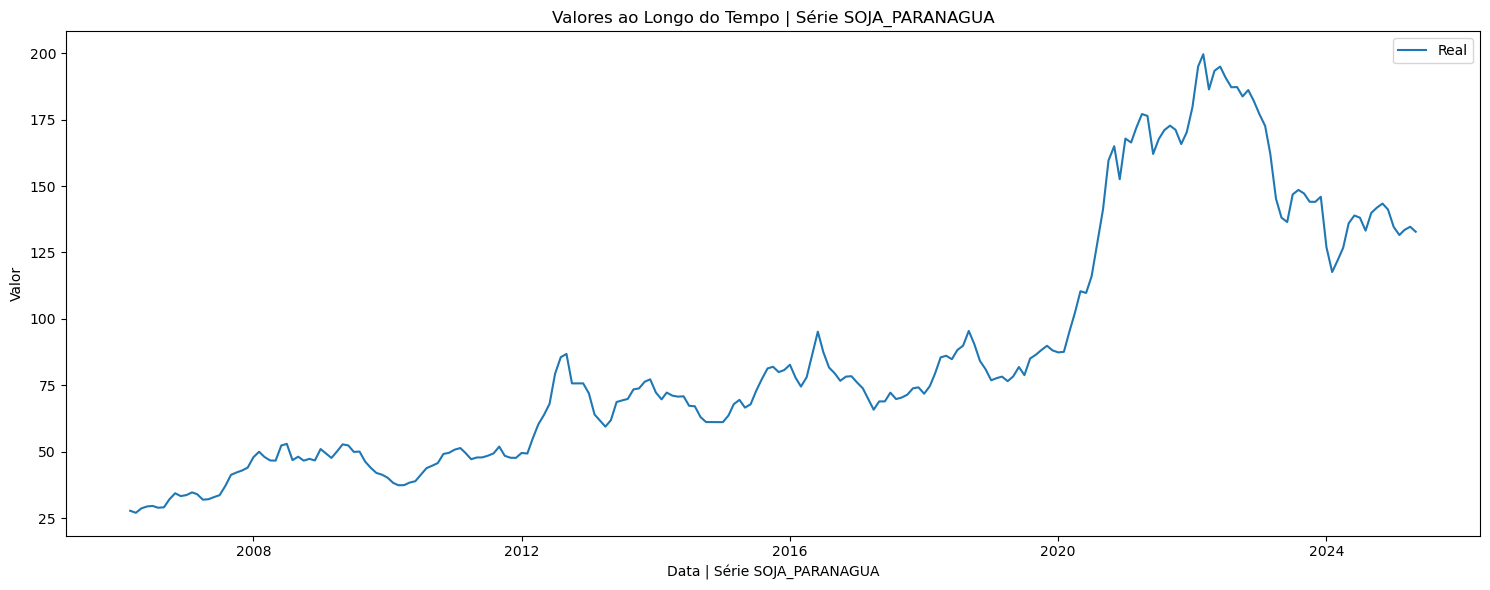

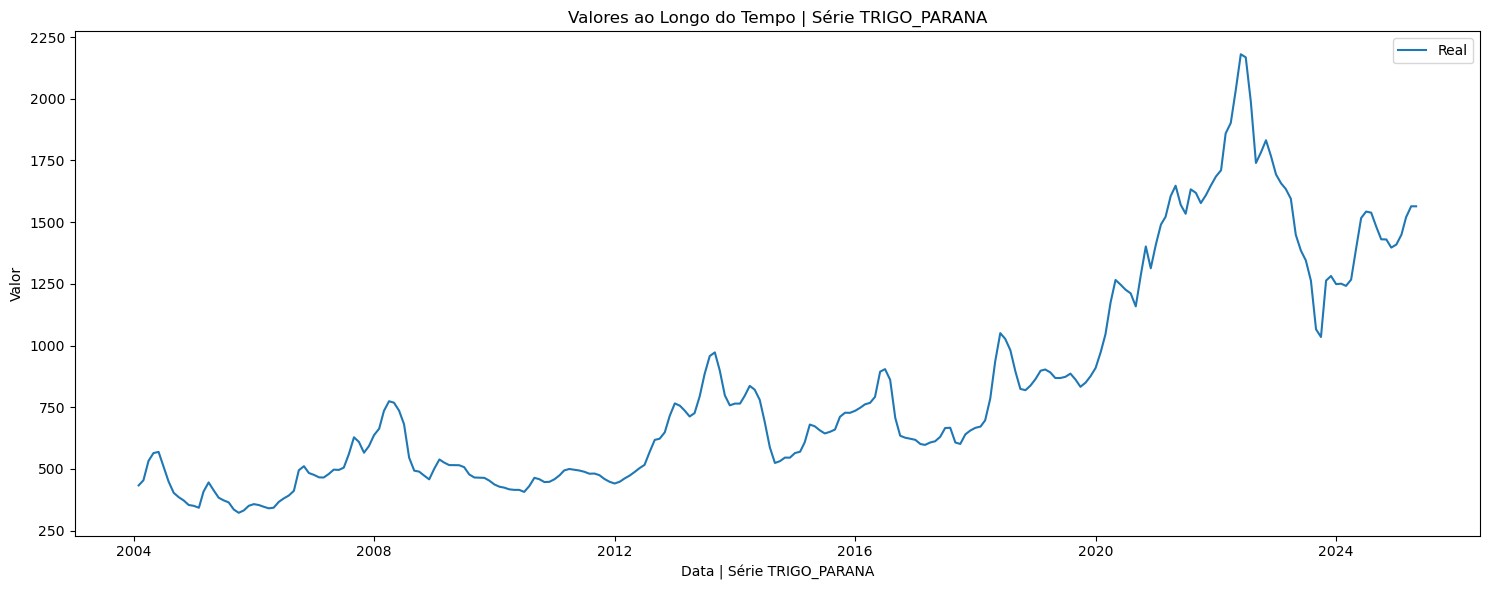

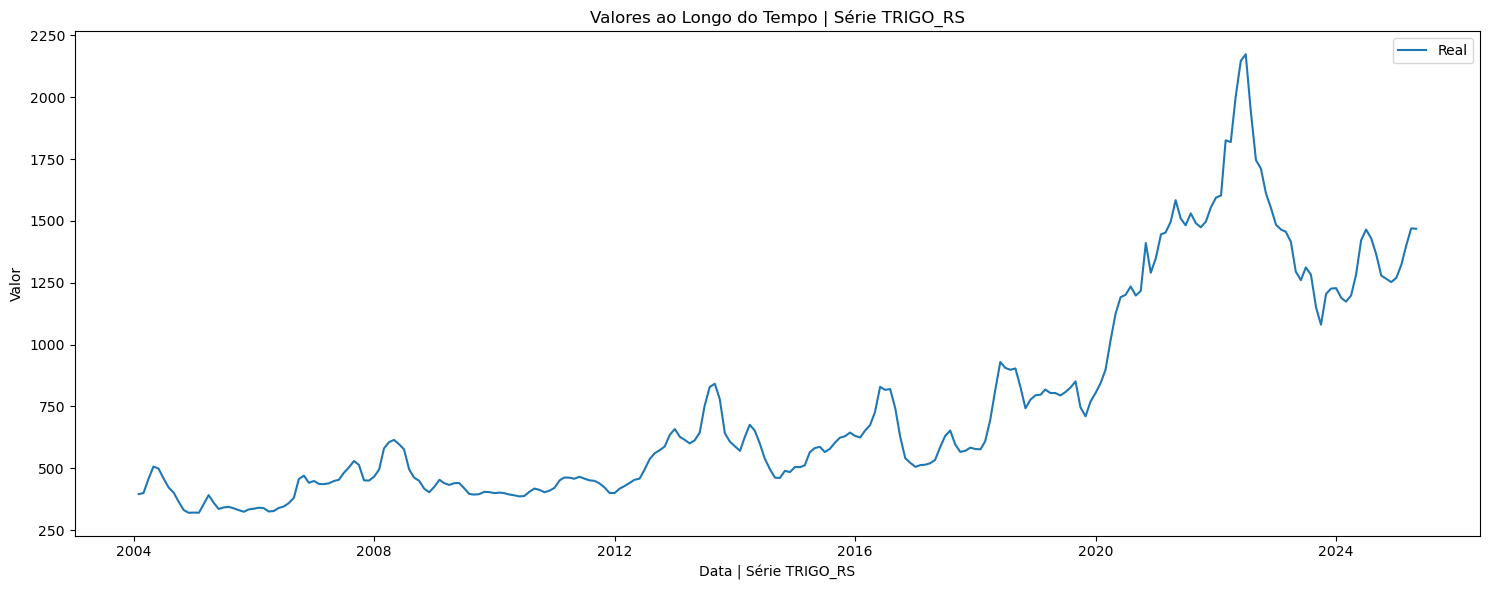

In [5]:
for uid in df_brl['unique_id'].unique():
  plt.figure(figsize=(15, 6))

  plt.plot(df_brl[df_brl['unique_id'] == uid]['ds'], df_brl[df_brl['unique_id'] == uid]['y'], label='Real')

  plt.title(f'Valores ao Longo do Tempo | Série {uid}')
  plt.xlabel(f'Data | Série {uid}')
  plt.ylabel('Valor')

  plt.legend()
  plt.tight_layout()
  plt.show()

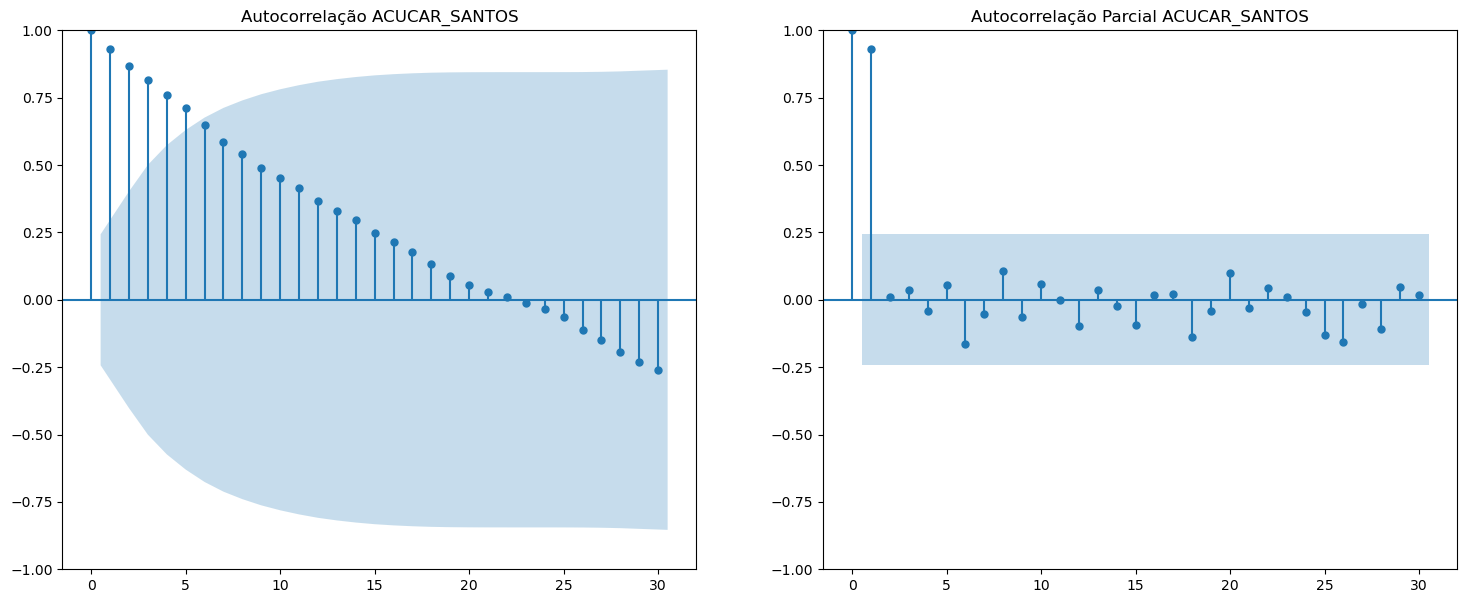

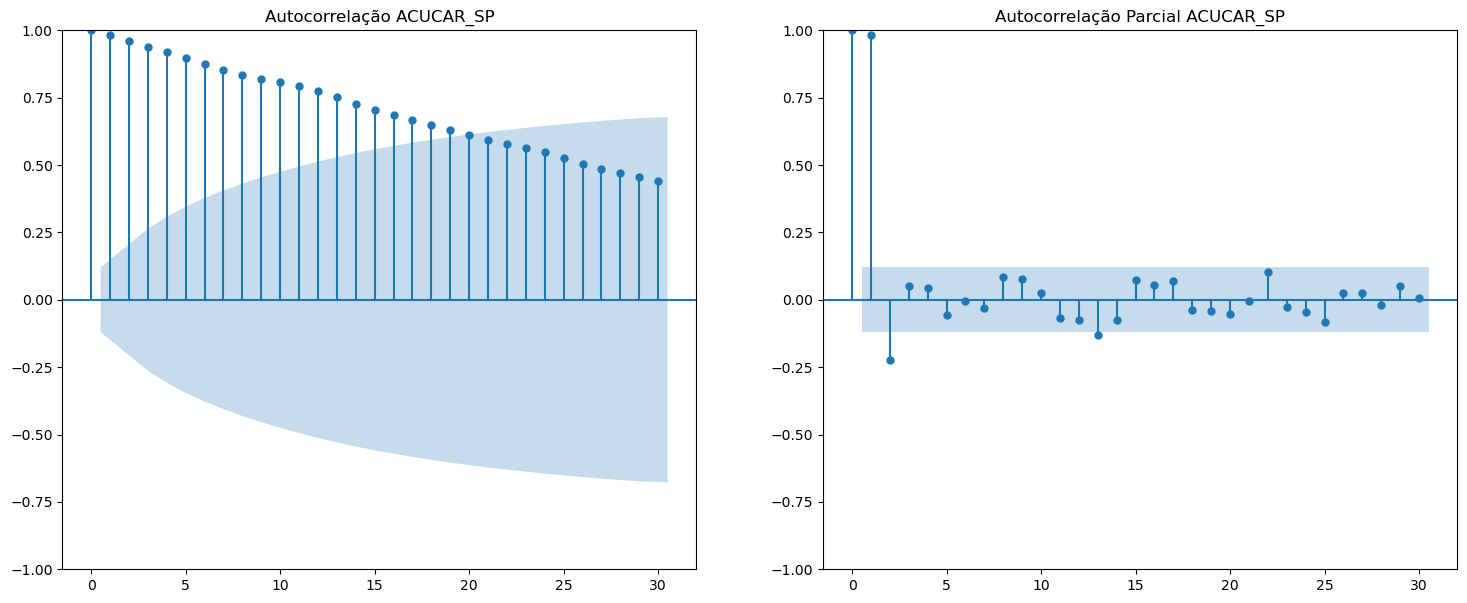

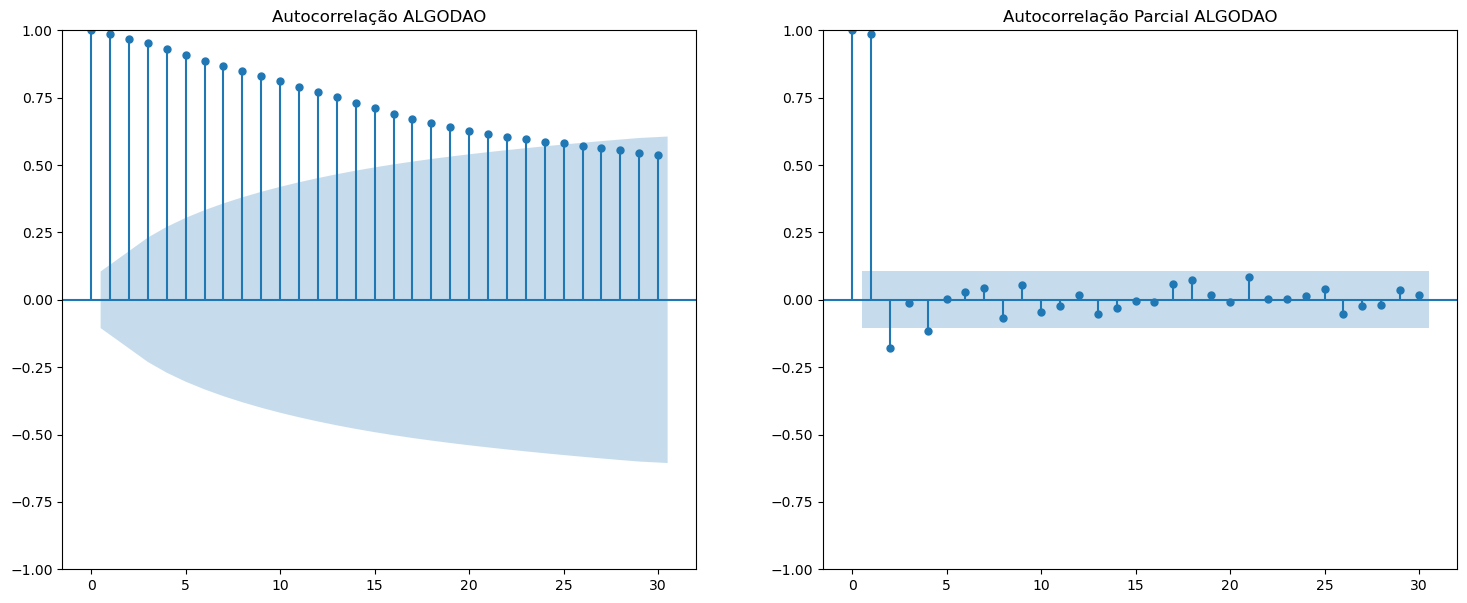

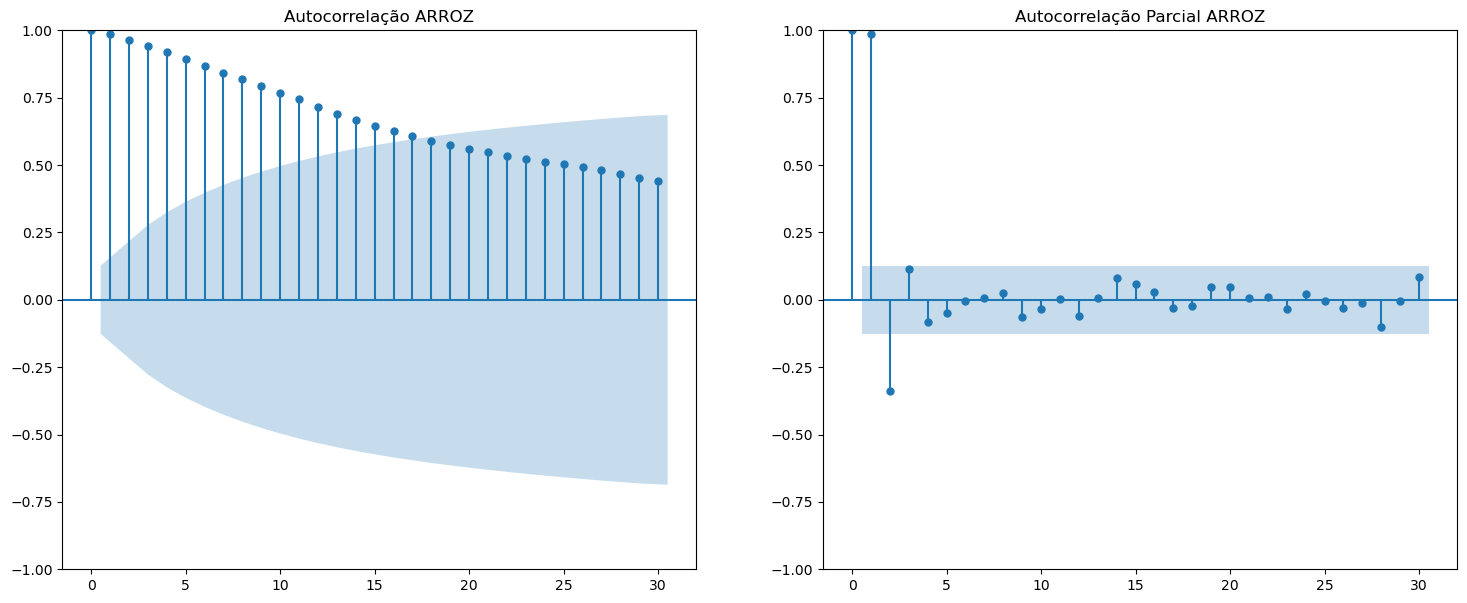

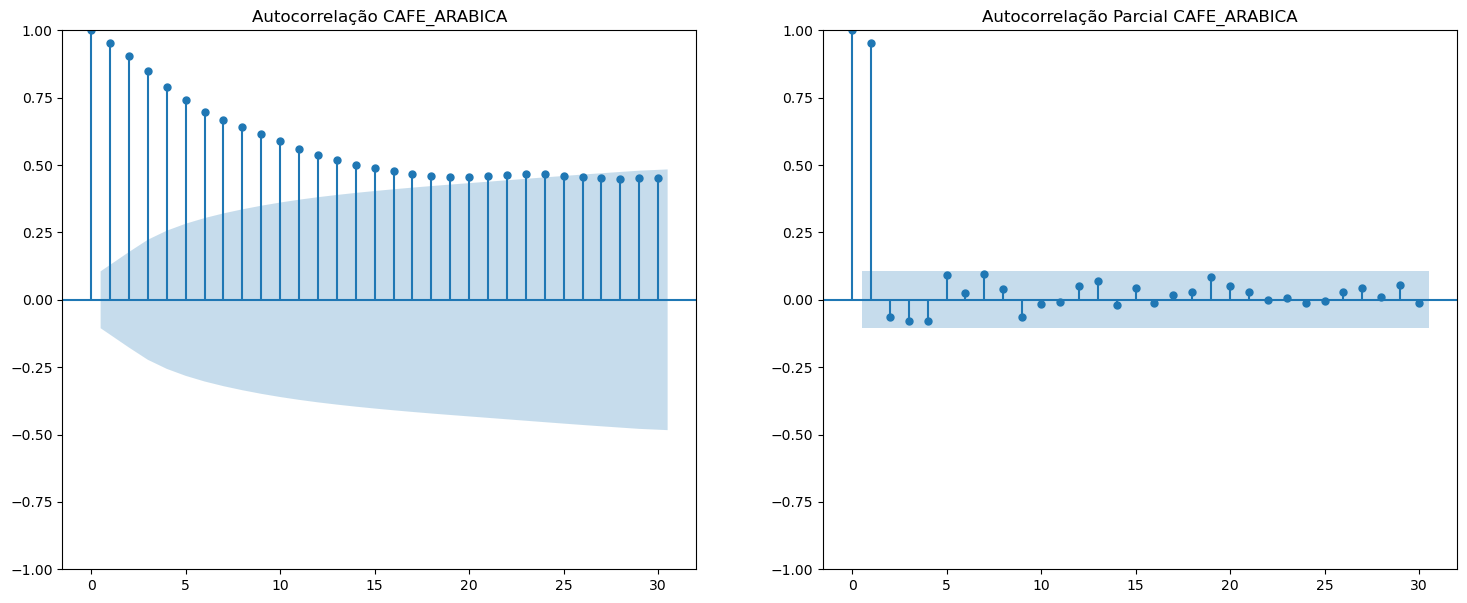

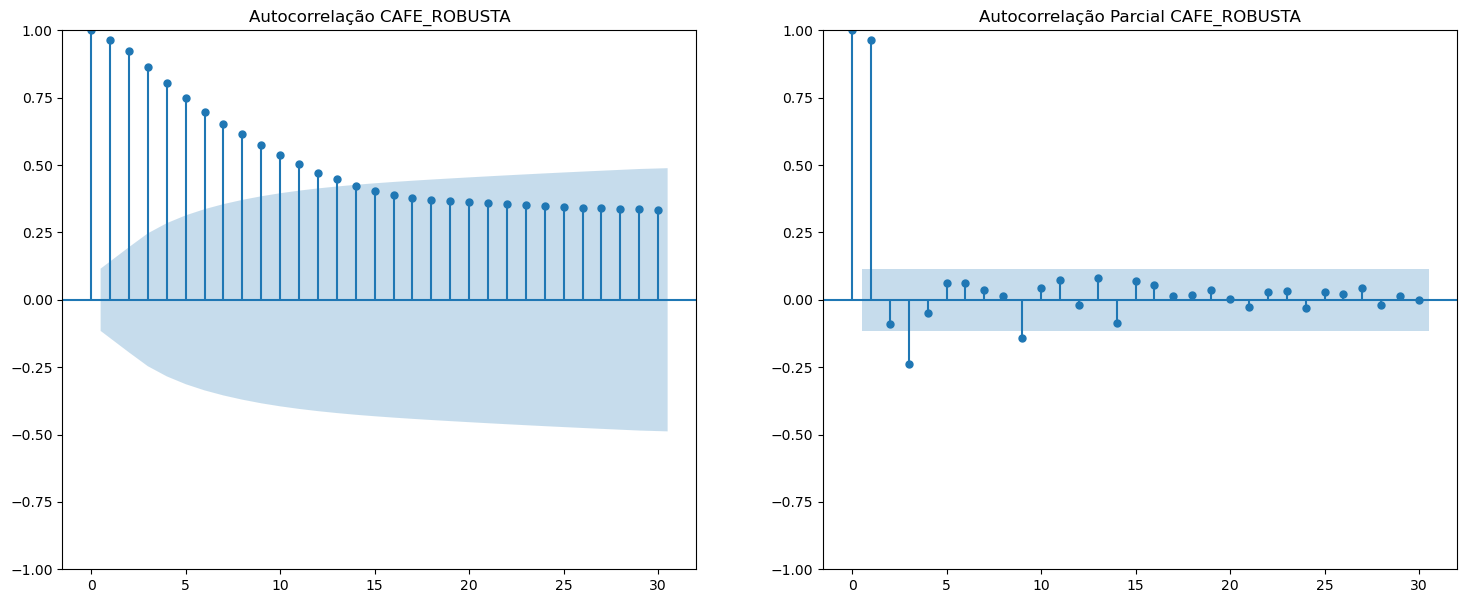

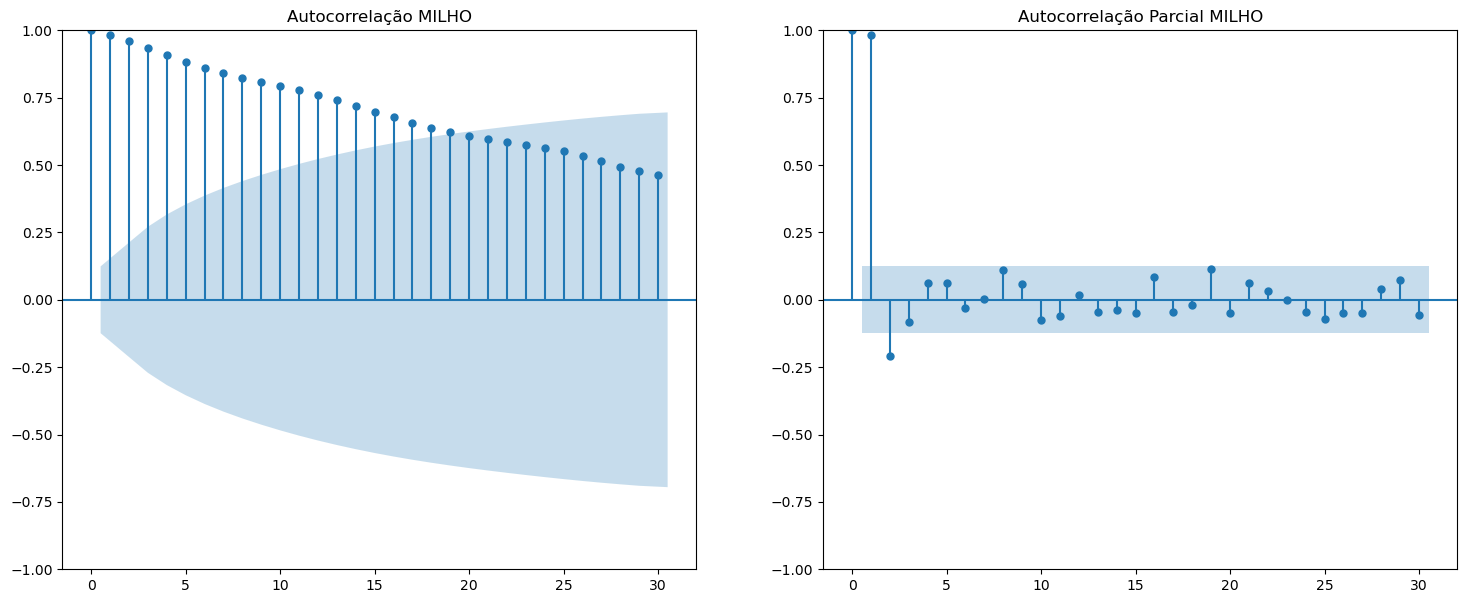

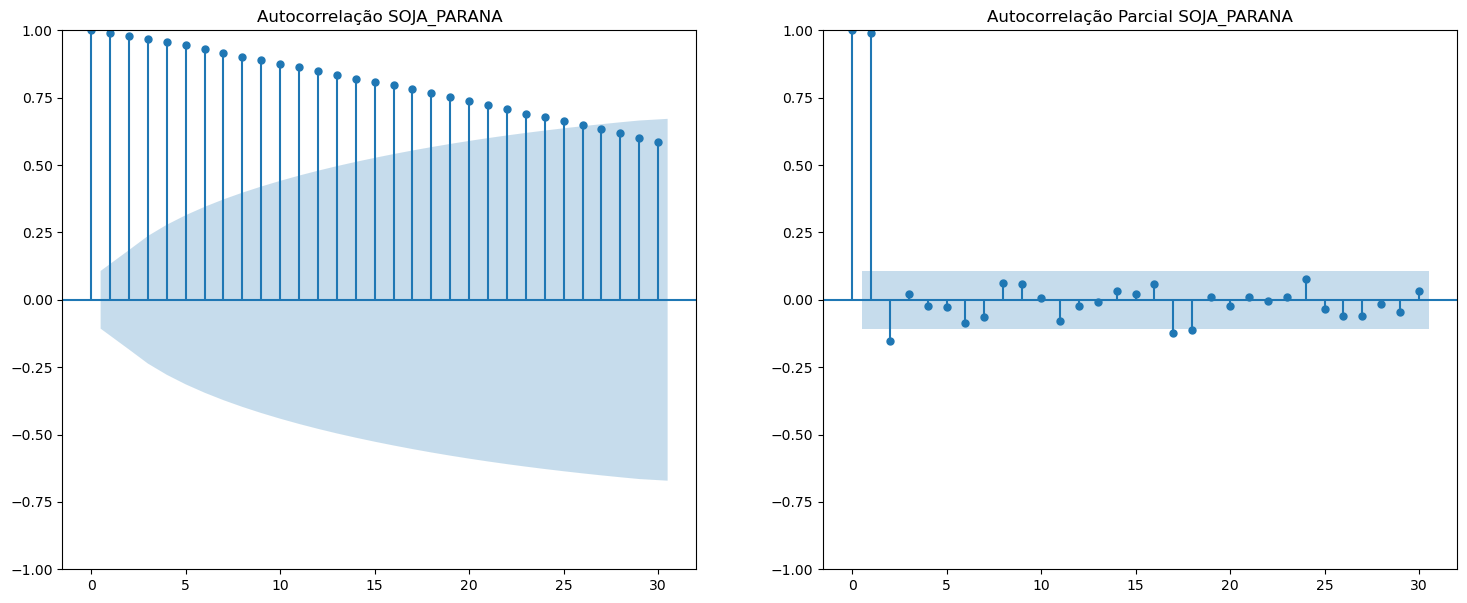

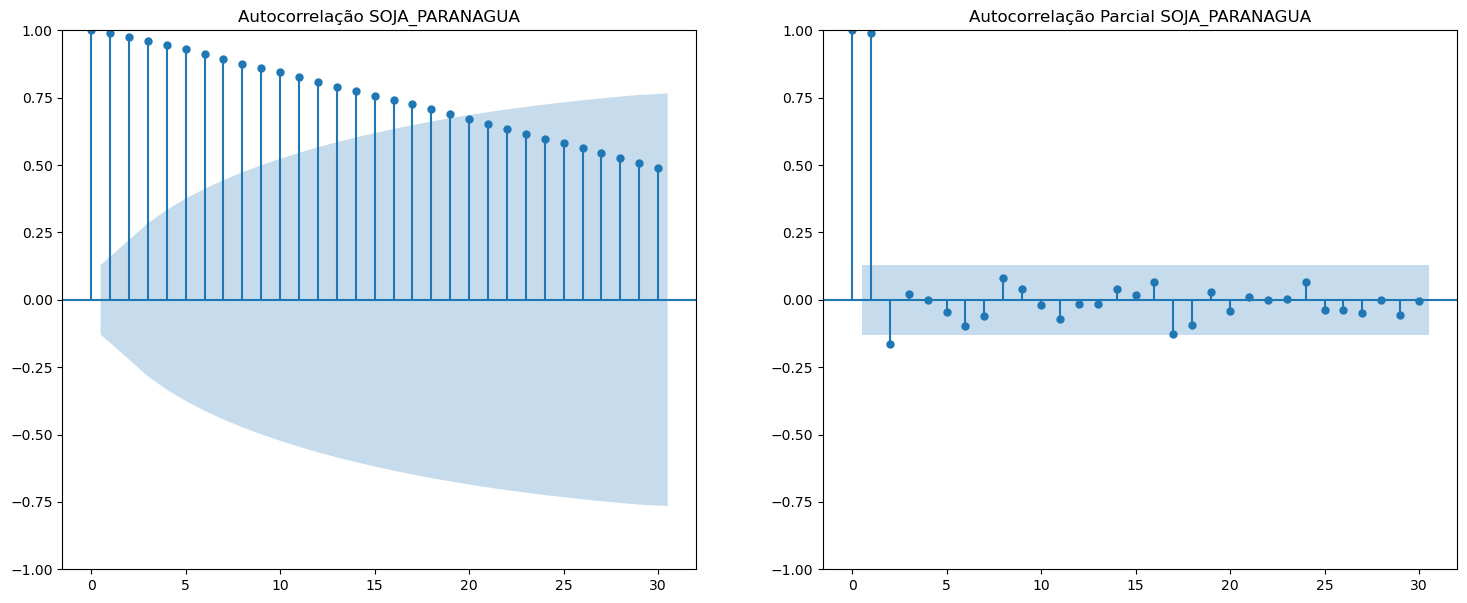

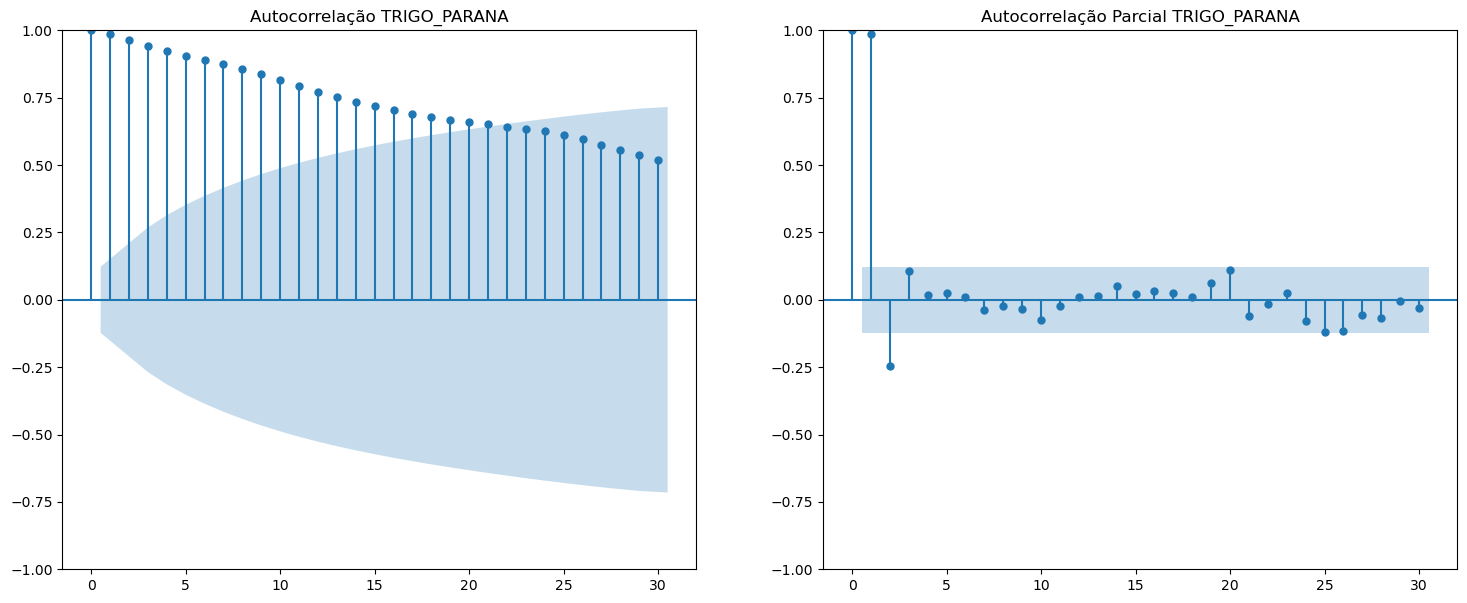

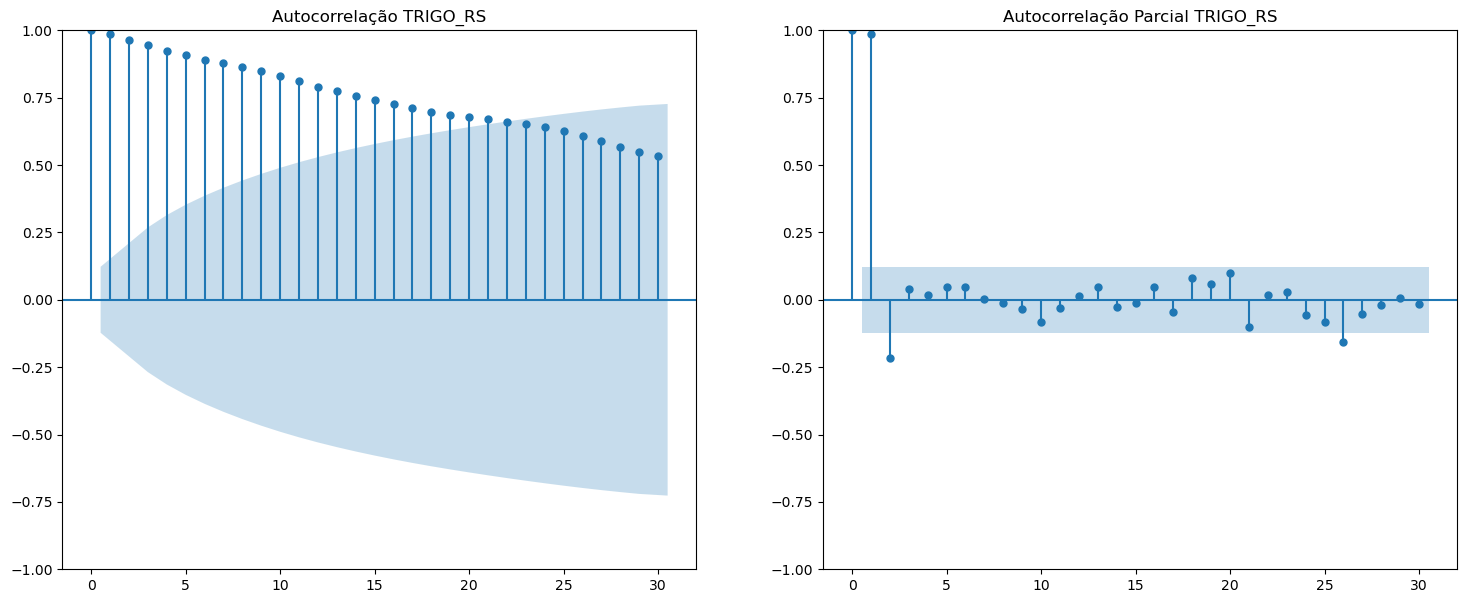

In [6]:
for u in df_brl['unique_id'].unique():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    plot_acf(df_brl[df_brl['unique_id'] == u]["y"],  lags=30, ax=axs[0])
    axs[0].set_title(f'Autocorrelação {u}');

    plot_pacf(df_brl[df_brl['unique_id'] == u]["y"],  lags=30, ax=axs[1])
    axs[1].set_title(f'Autocorrelação Parcial {u}')

    plt.show();

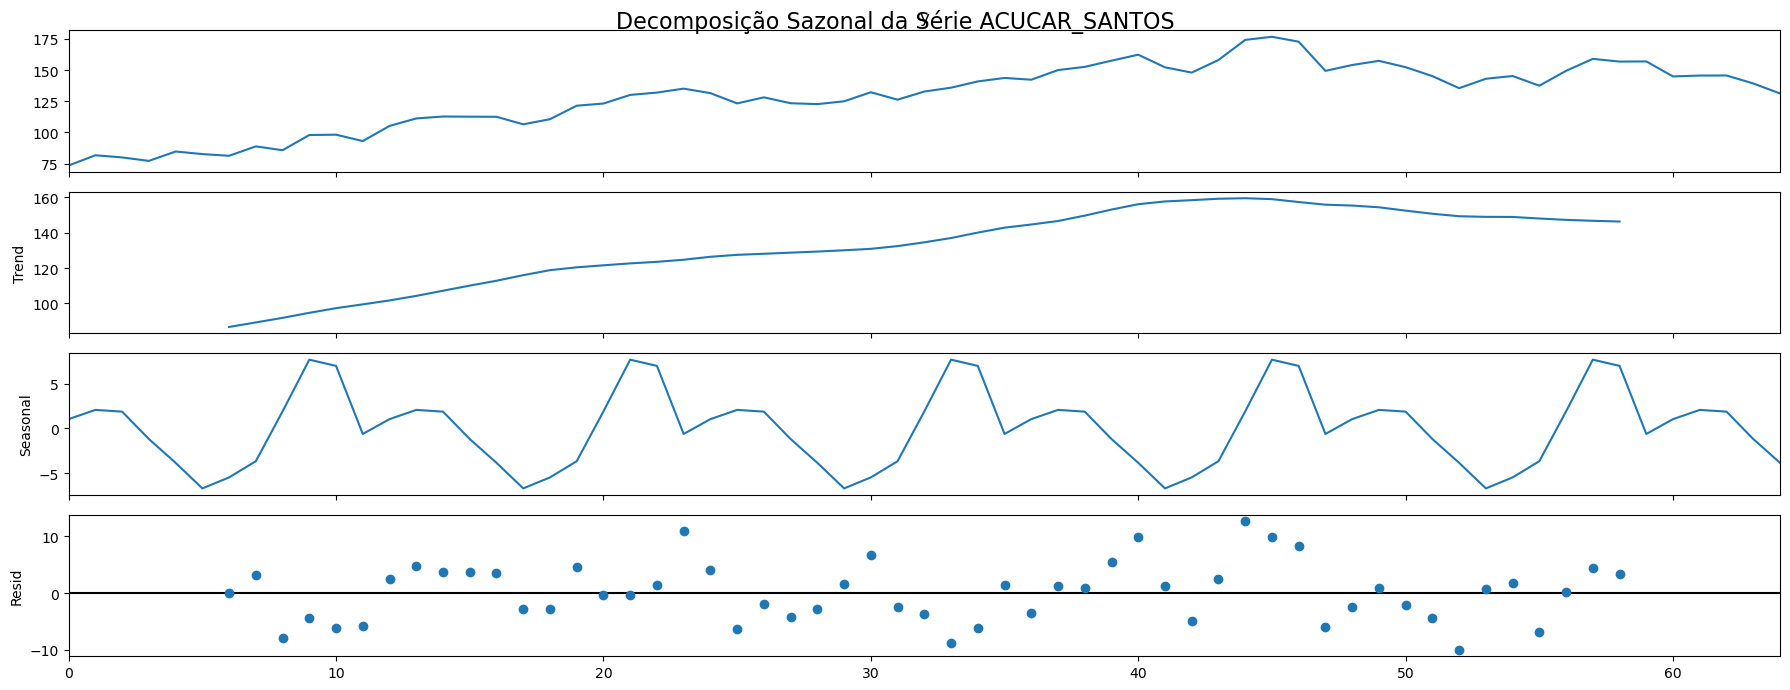

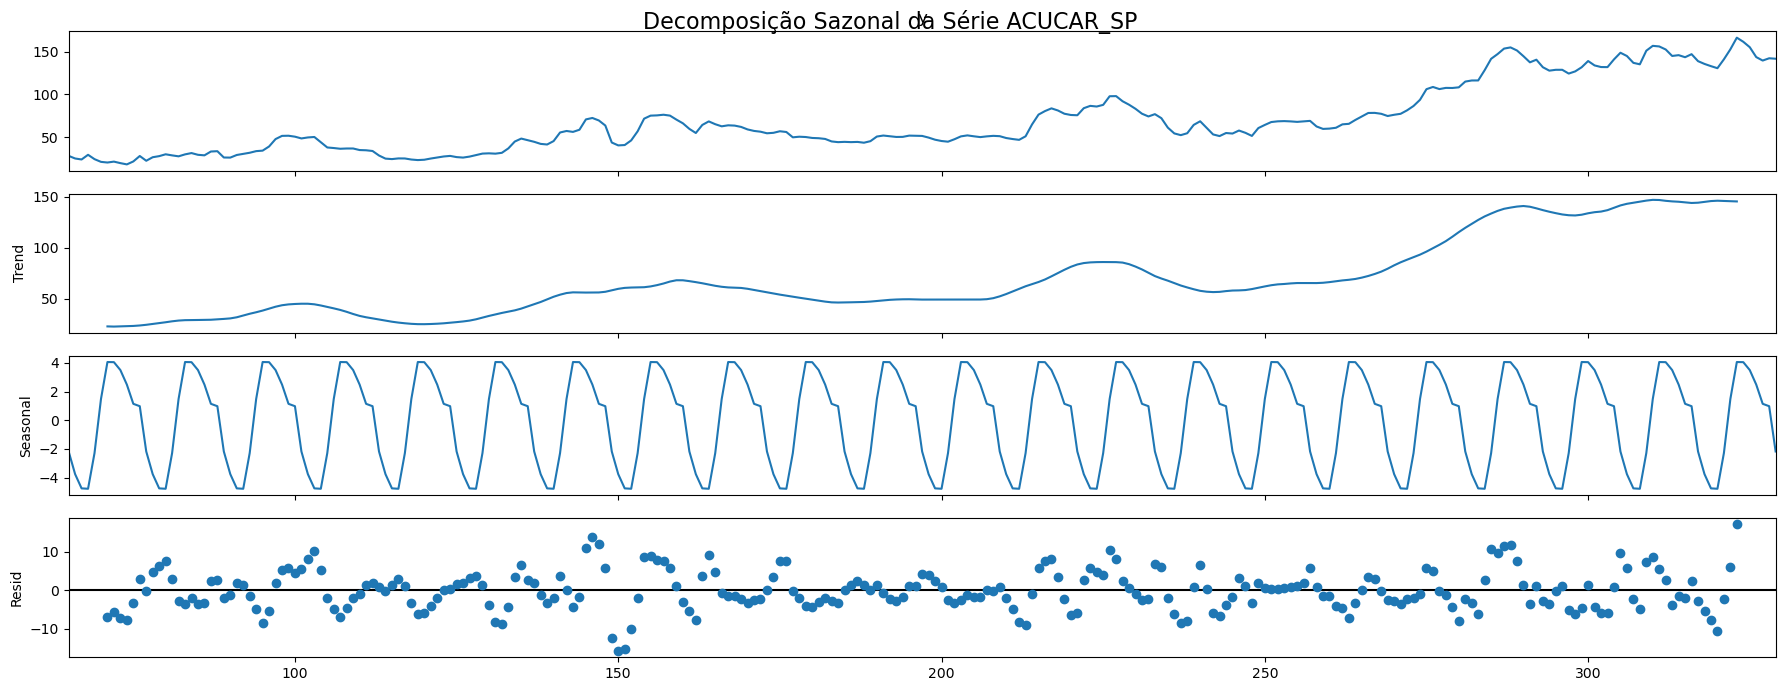

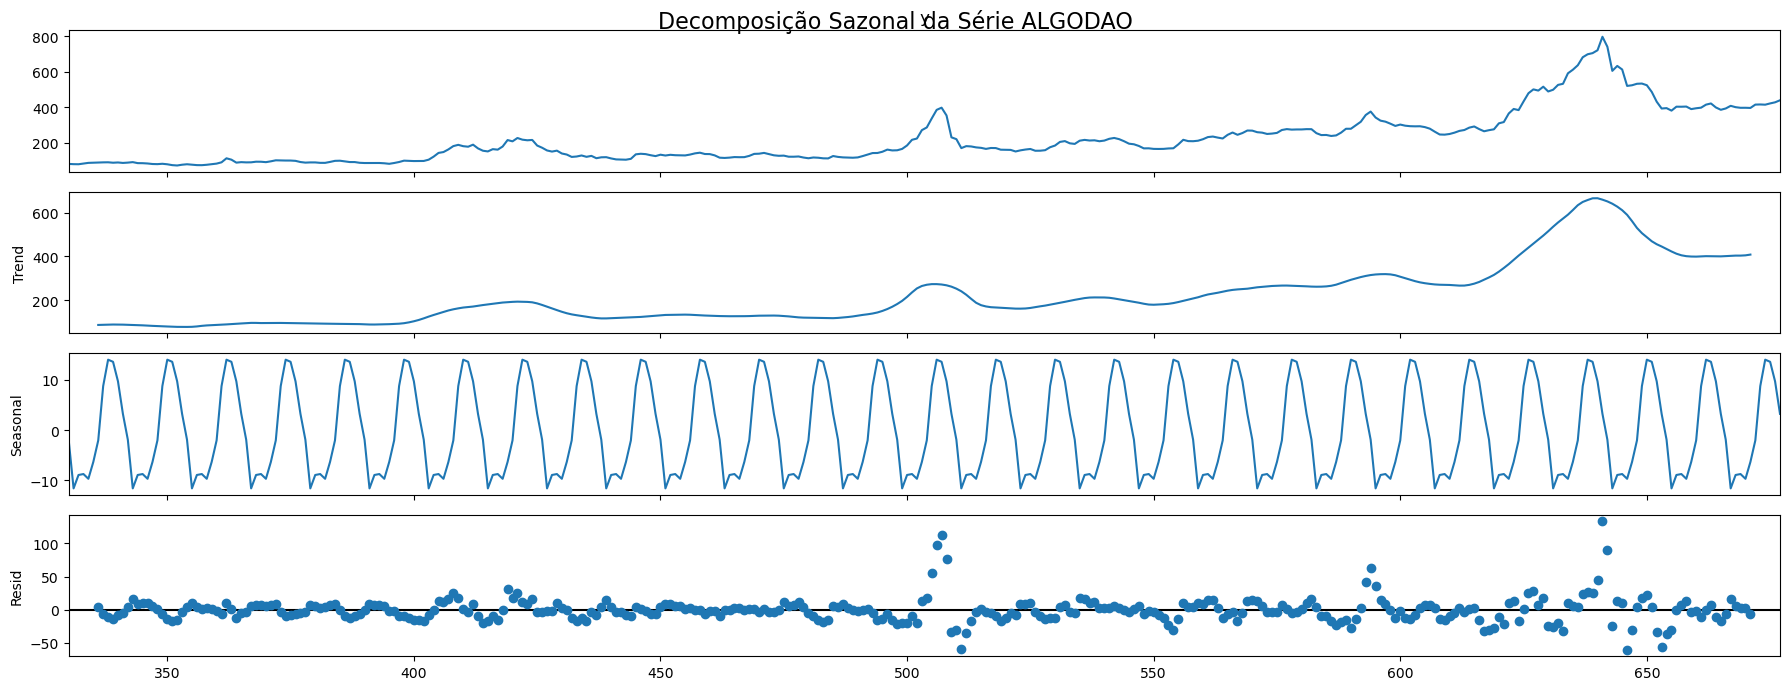

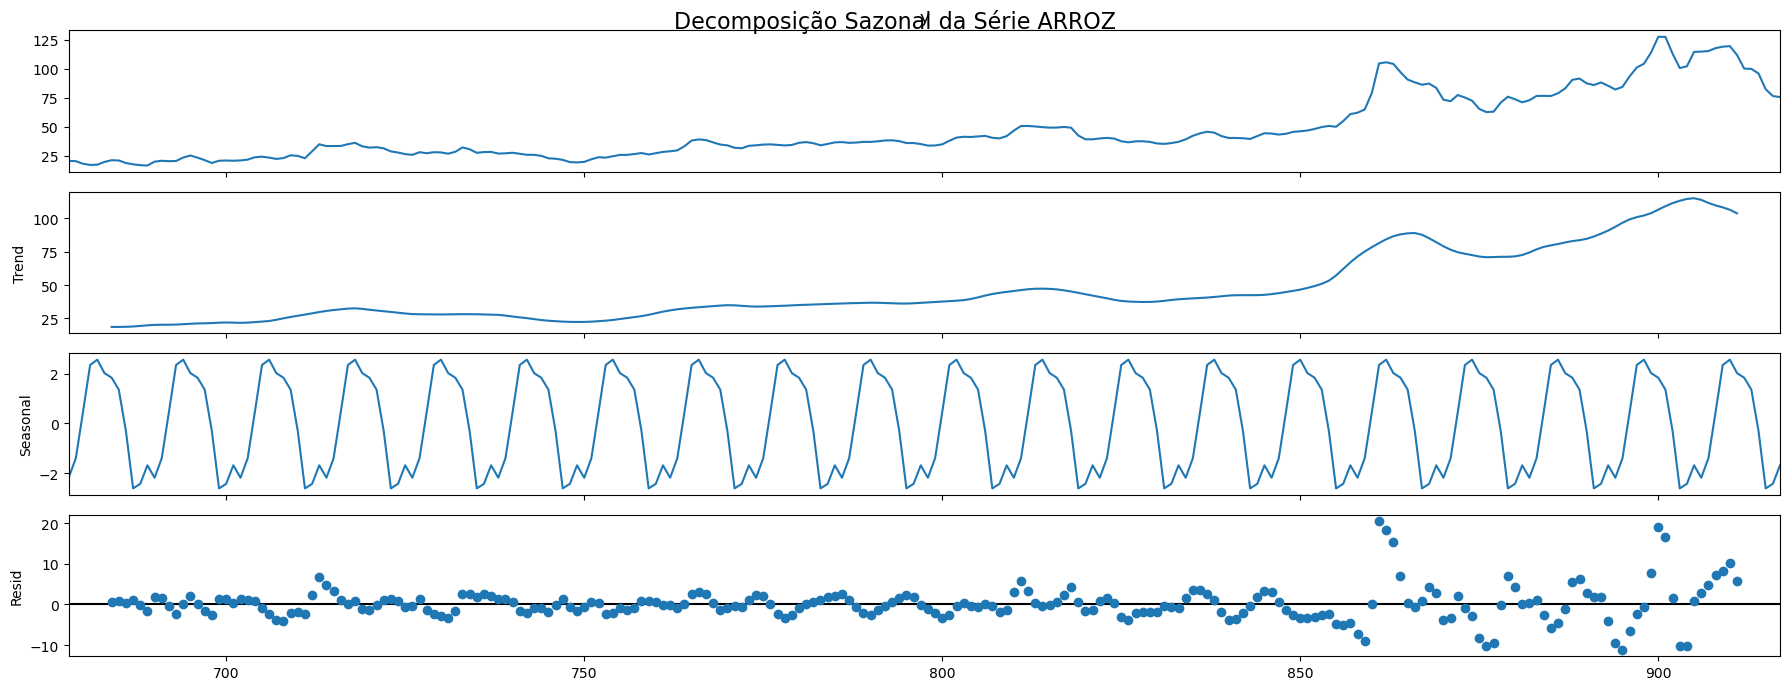

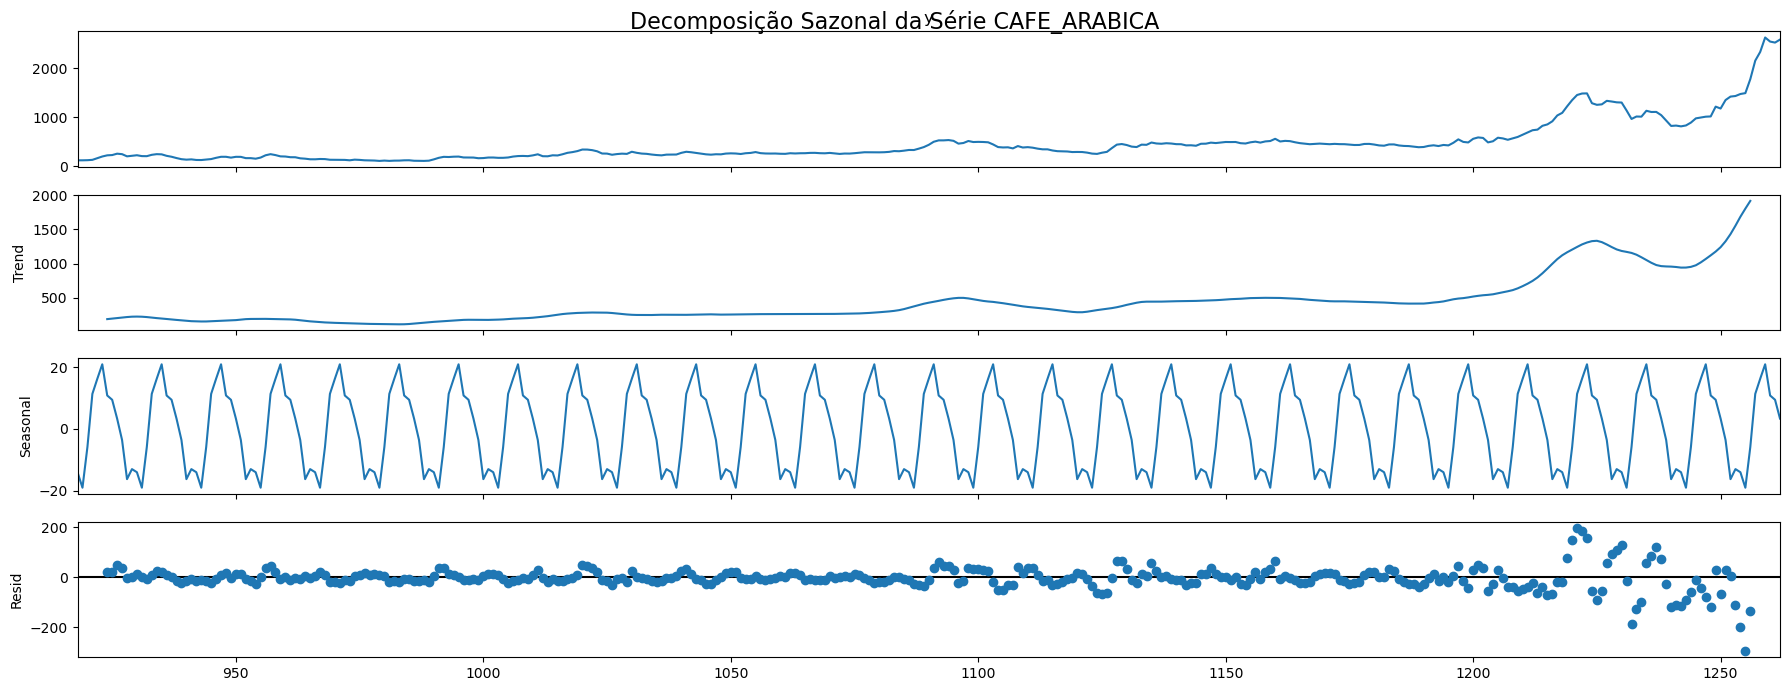

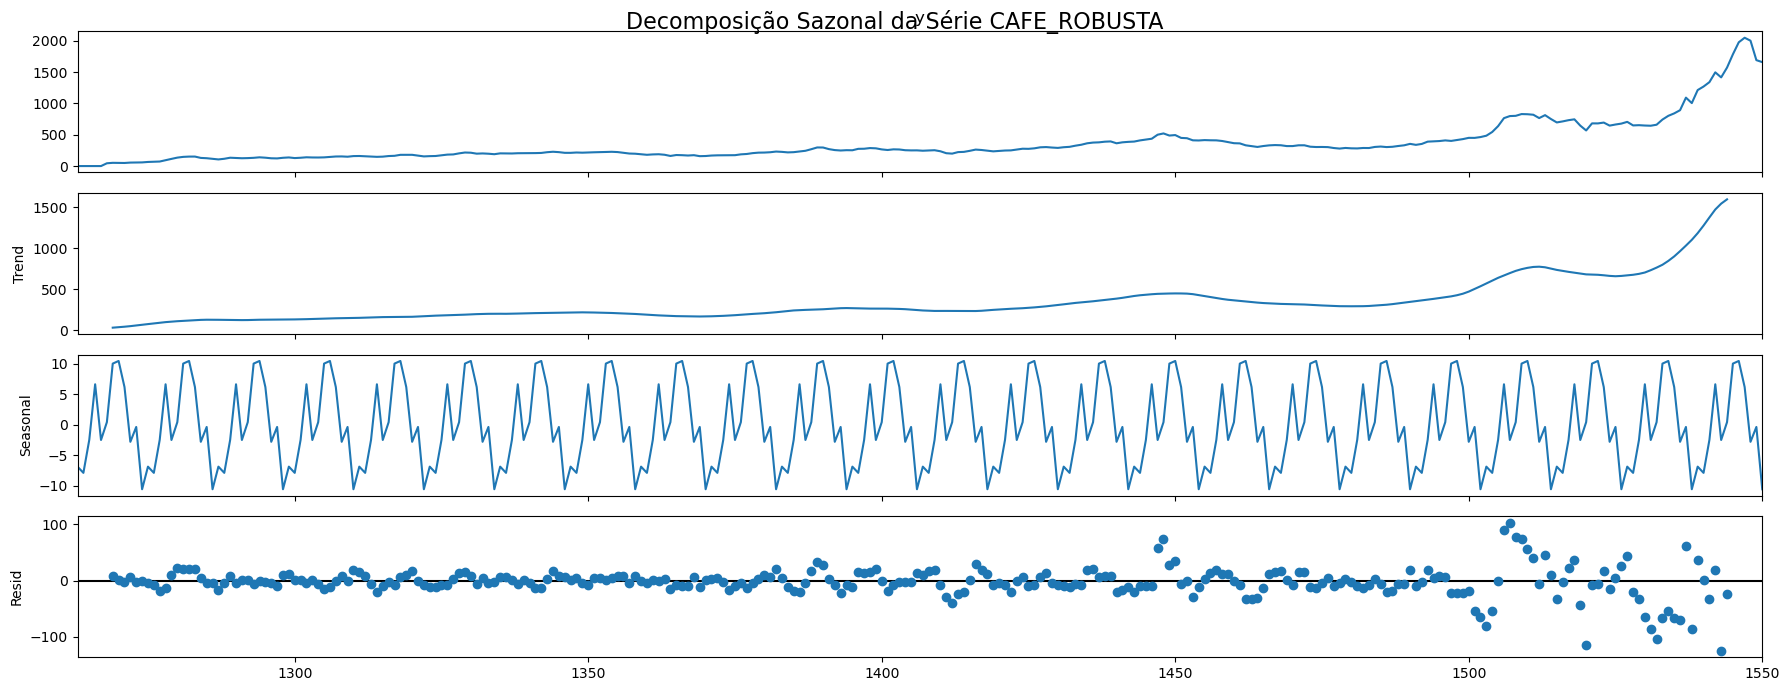

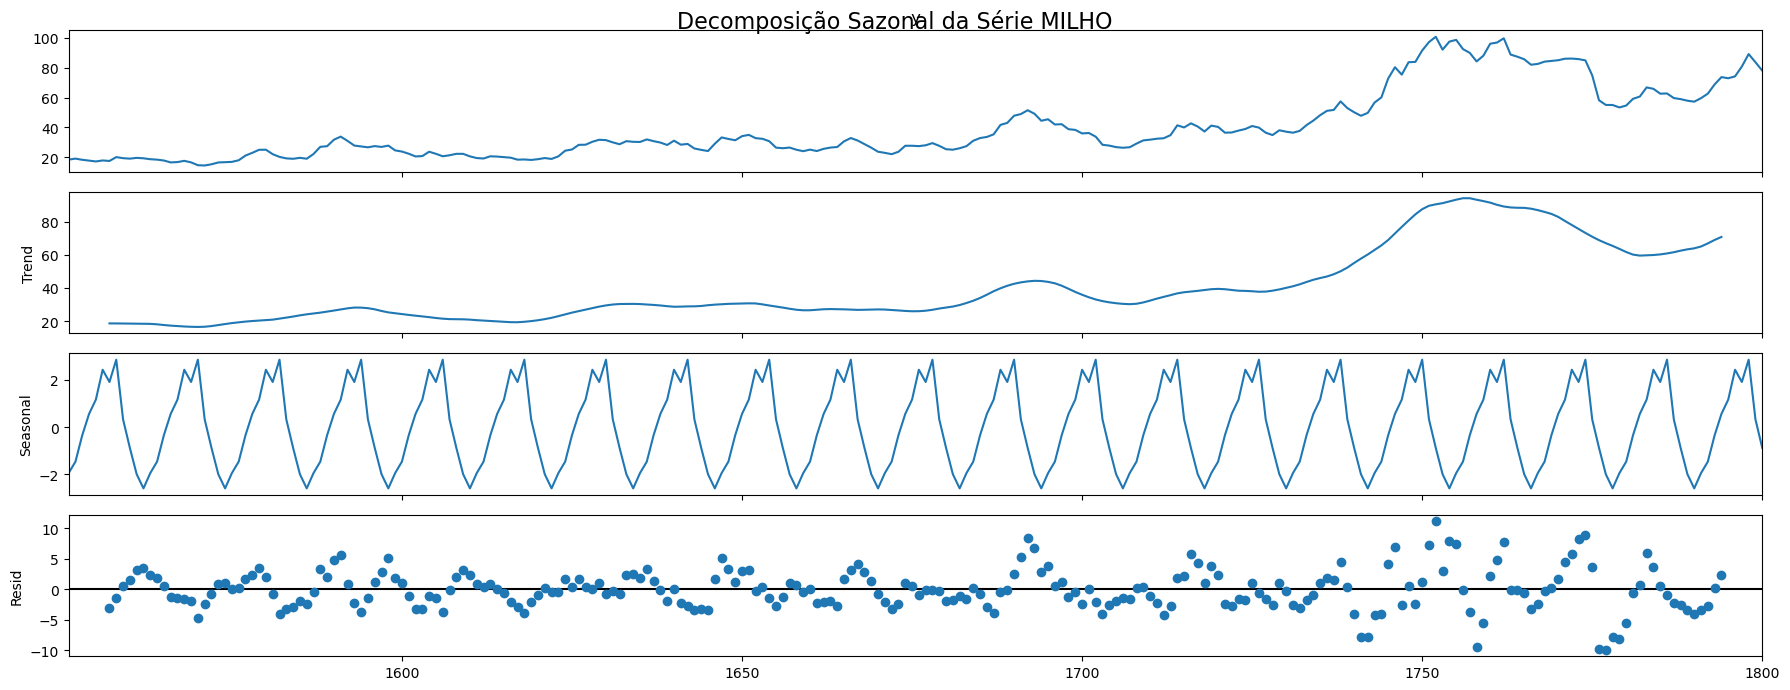

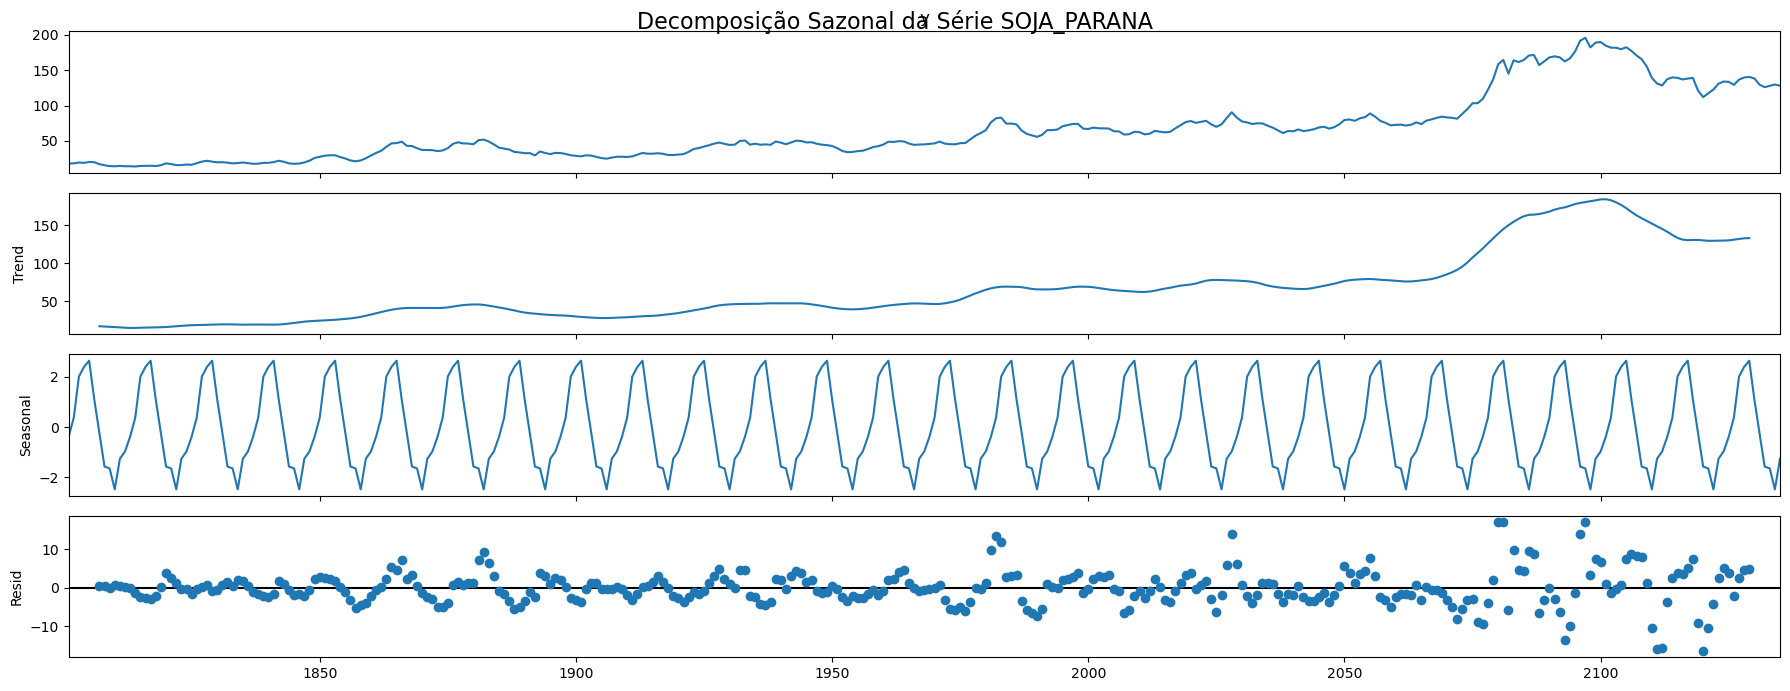

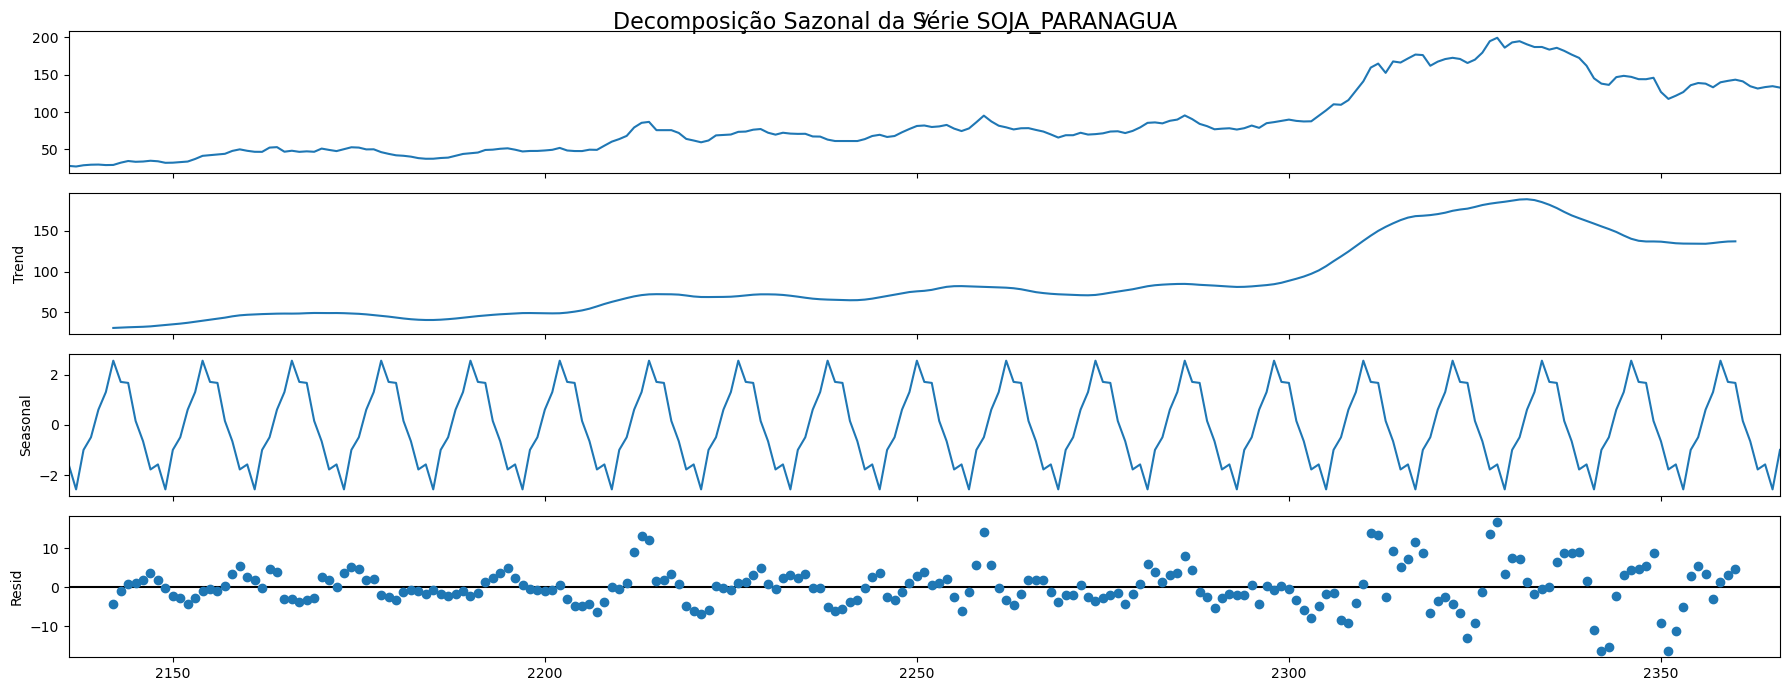

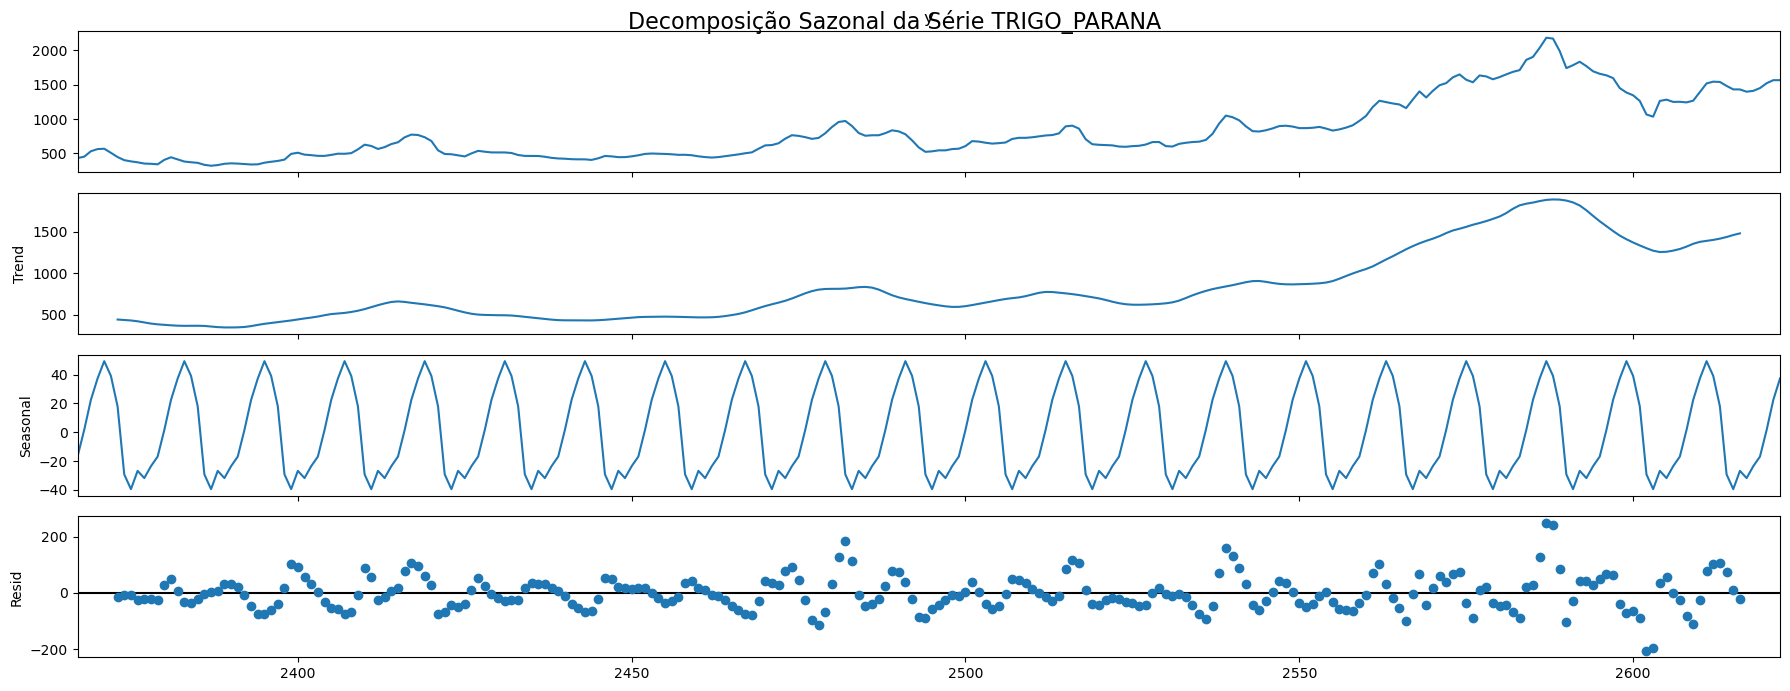

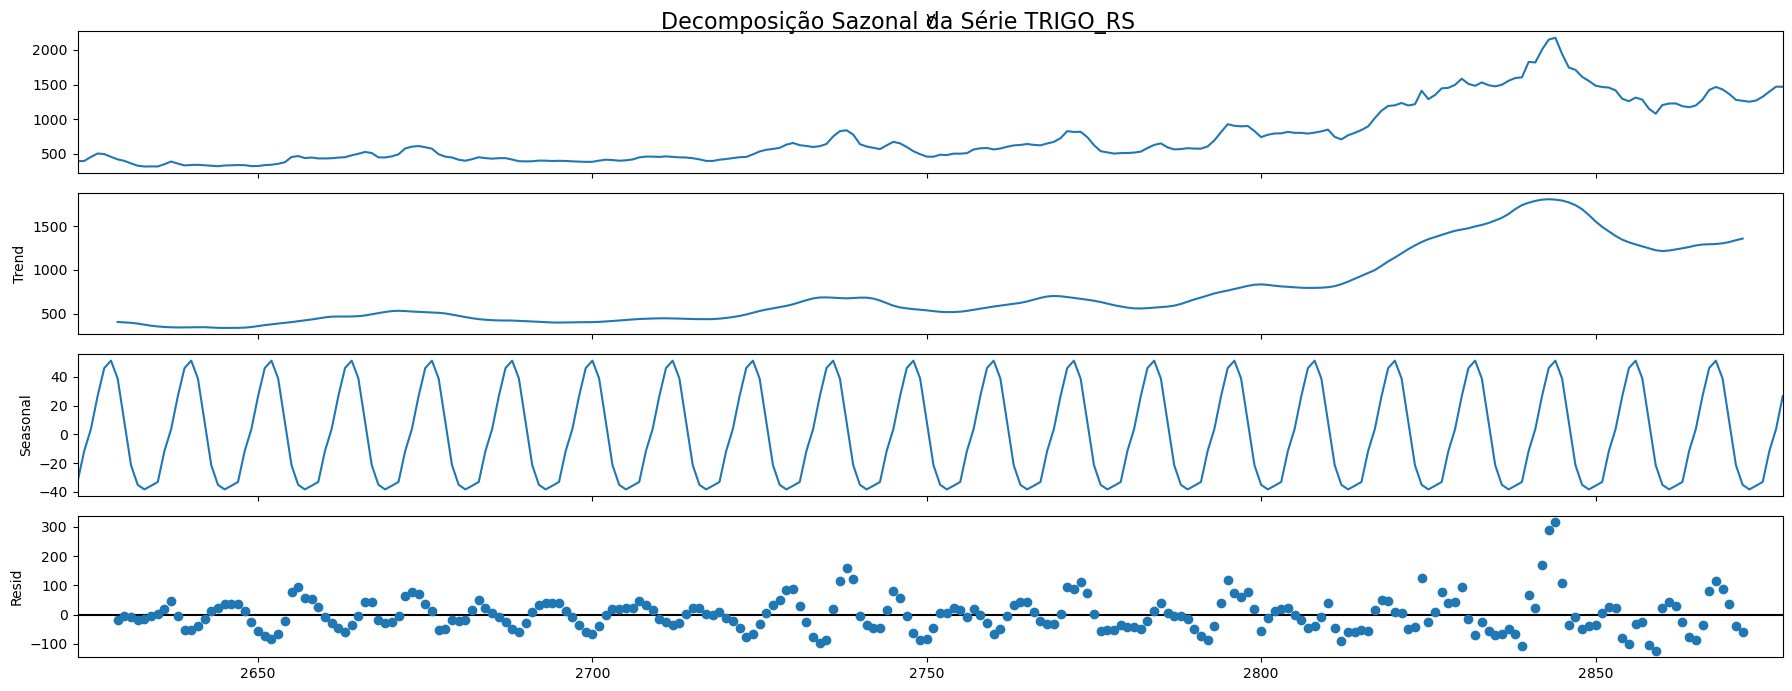

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 

for u in df_brl['unique_id'].unique():
    a = seasonal_decompose(df_brl[df_brl['unique_id'] == u]["y"], model = "add", period=12)
    fig = a.plot()

    fig.suptitle(f"Decomposição Sazonal da Série {u}", fontsize=16)

    plt.show()

In [7]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [8]:
season_length = 12

models = [
    AutoARIMA(season_length=season_length),
    AutoETS(model='AZN')
]

In [9]:
sf = StatsForecast(models=models, freq='MS')

In [10]:
def plot_single_series_and_forecasts(df_brl, forecasts_df, test_size):
    """
    Plota a série completa e as previsões para a única série presente no df
    """
    uid = df_brl['unique_id'].unique()[0]  # pega o único valor existente
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    series_data = df_brl.copy()
    train_data = df_brl.iloc[:-test_size].copy()
    test_data = df_brl.iloc[-test_size:].copy()
    print(len(test_data))
    true_forecast = forecasts_df[forecasts_df['unique_id'] == uid].copy()

    # Série completa
    ax.plot(series_data['ds'], series_data['y'], 
            color='lime', linewidth=1.5, label='Série Completa')

    # Treino
    ax.plot(train_data['ds'], train_data['y'], 
            color='cyan', linewidth=2, label='Treino')

    # Teste real
    ax.plot(test_data['ds'], test_data['y'], 
            color='fuchsia', linewidth=2, label='Teste (Real)')

    # Previsões
    ax.plot(true_forecast['ds'], true_forecast['AutoARIMA'], 
            color='red', linewidth=2, linestyle='--', label='Previsão AutoARIMA em teste')

    ax.plot(true_forecast['ds'], true_forecast['AutoETS'], 
            color='blue', linewidth=2, linestyle='--', label='Previsão AutoETS em teste')

    # Linha vertical início teste
    if len(test_data) > 0:
        ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                  linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')

    # Configurações do gráfico
    ax.set_title(f'Série Temporal e Previsões - {uid}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Preço', fontsize=12)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Gráfico exibido para: {uid}")
    print("-" * 50)

#### Full


=== Rodando Cross Validation para ACUCAR_SANTOS (Teste=20) ===
20


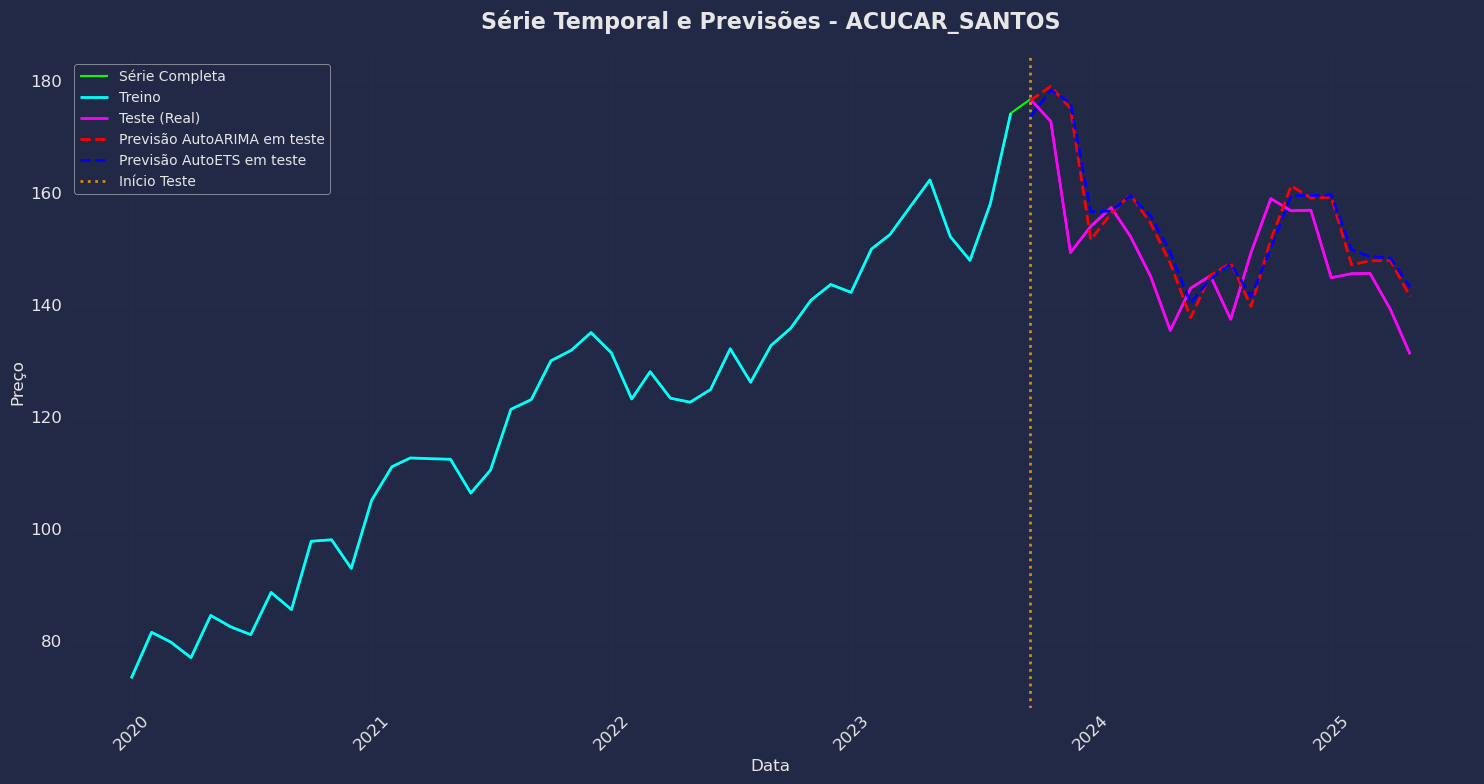

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------

=== Rodando Cross Validation para ACUCAR_SP (Teste=80) ===
80


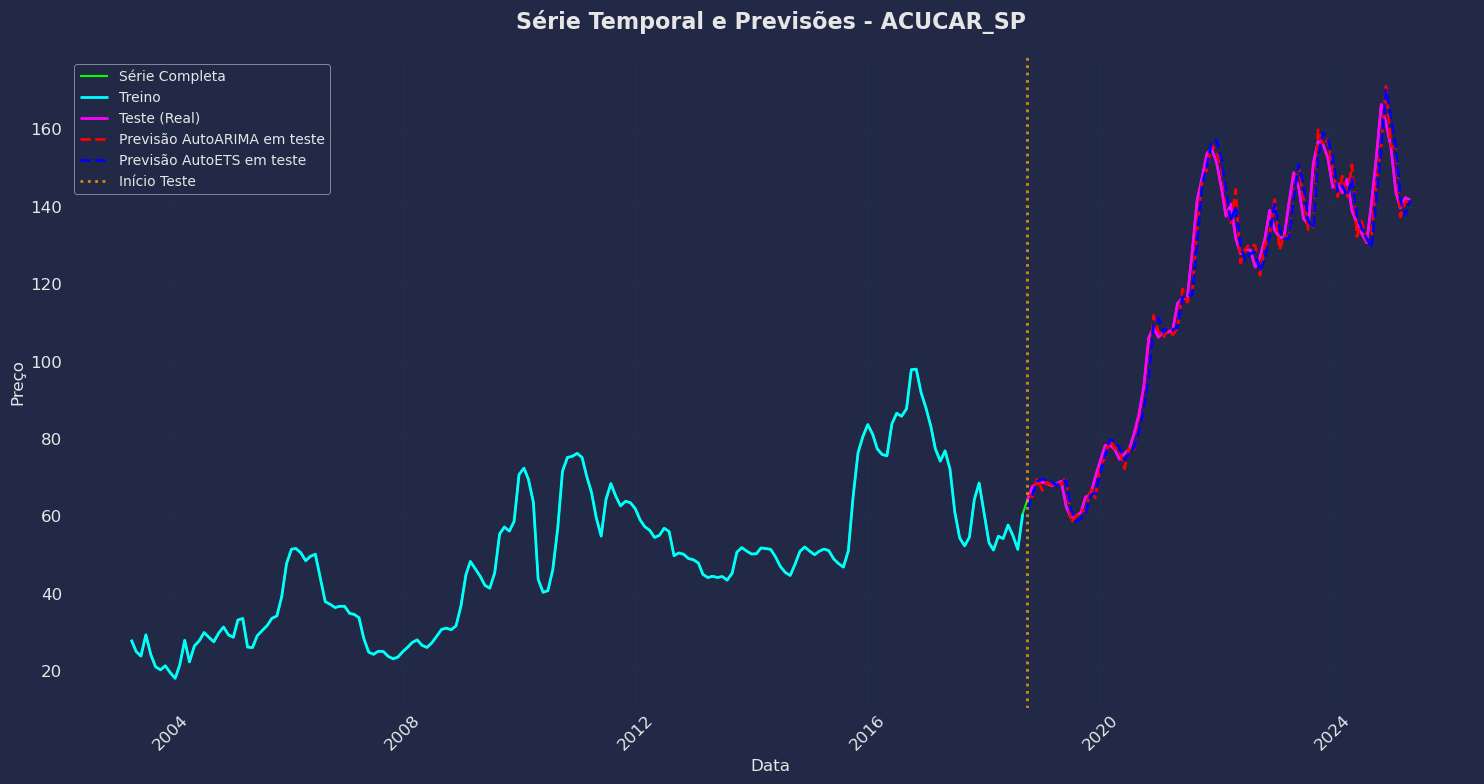

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------

=== Rodando Cross Validation para ALGODAO (Teste=105) ===
105


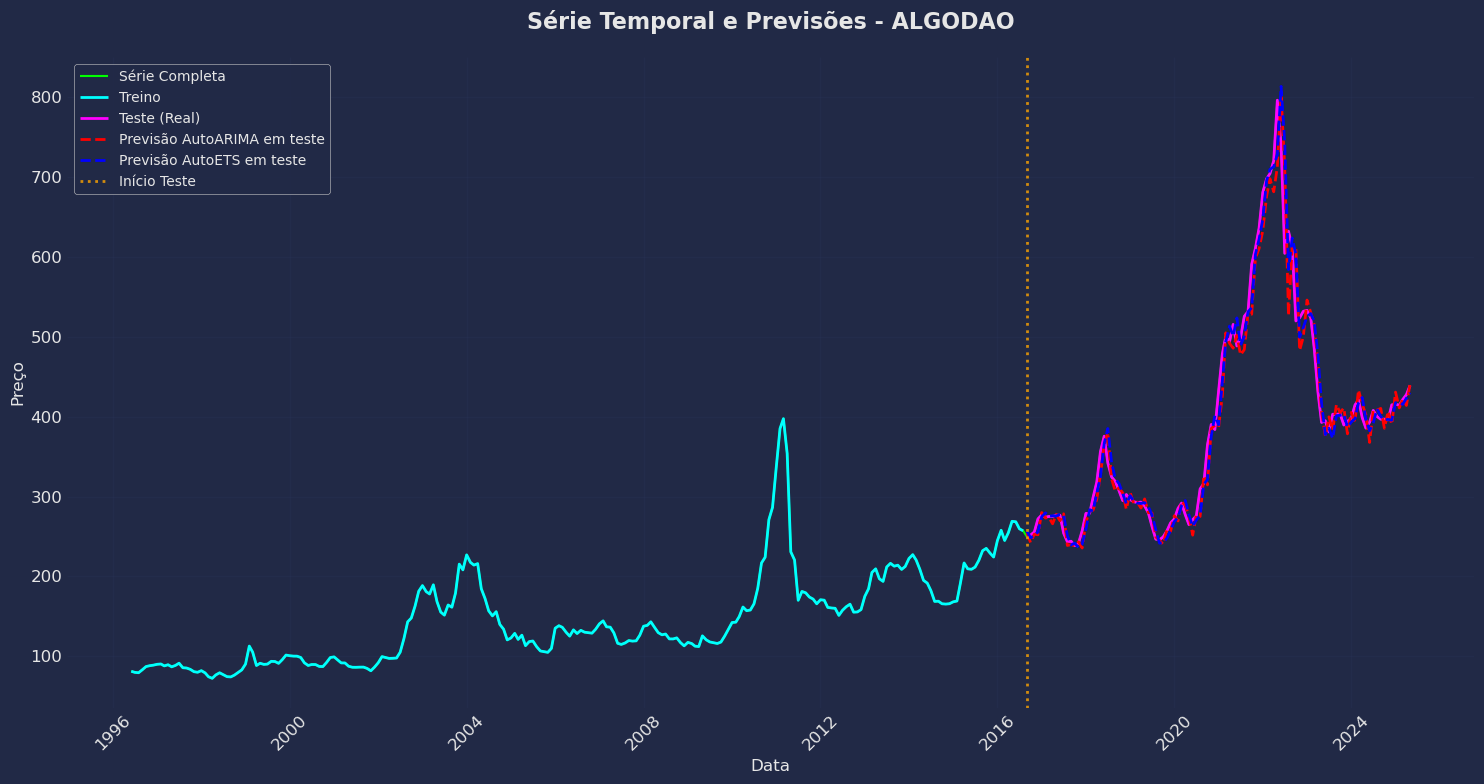

Gráfico exibido para: ALGODAO
--------------------------------------------------

=== Rodando Cross Validation para ARROZ (Teste=72) ===
72


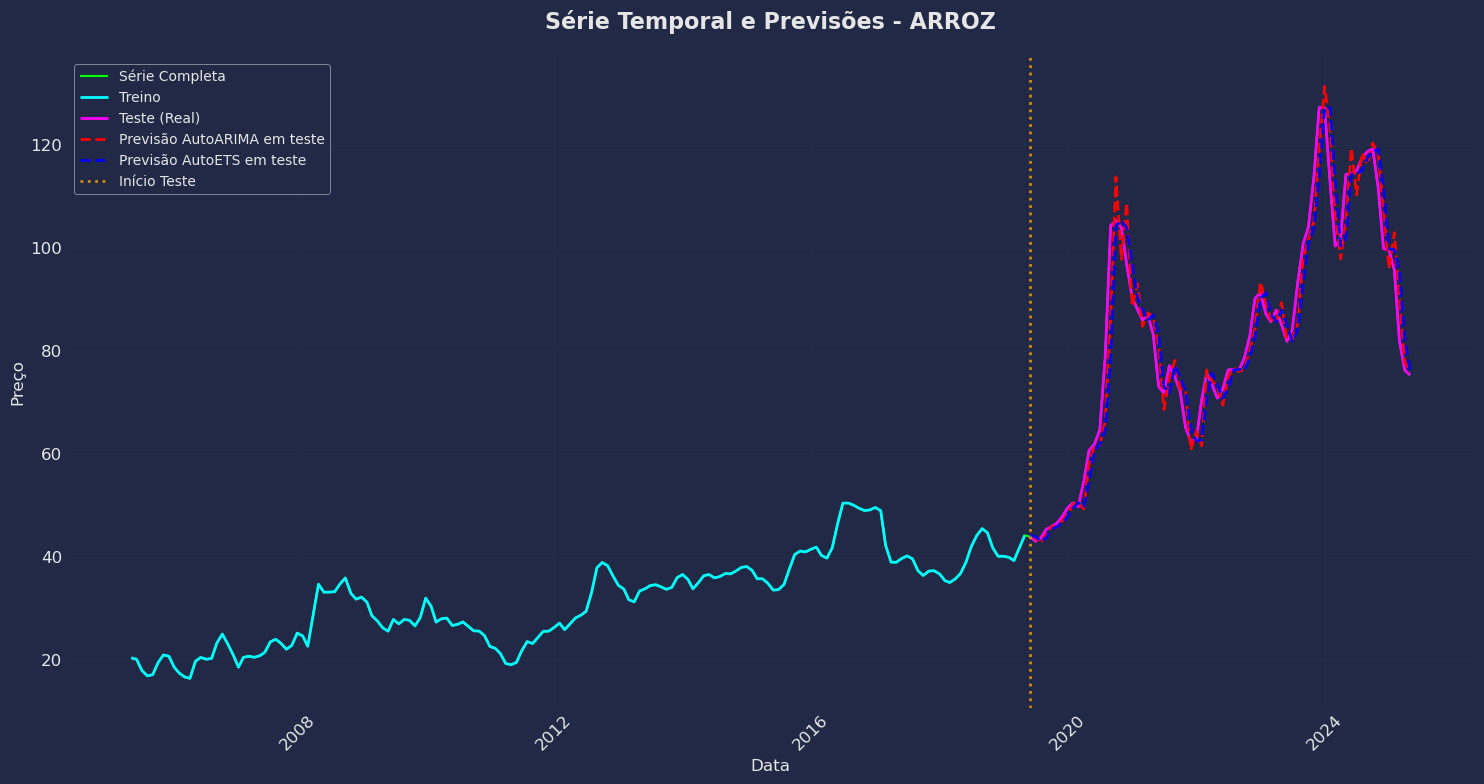

Gráfico exibido para: ARROZ
--------------------------------------------------

=== Rodando Cross Validation para CAFE_ARABICA (Teste=104) ===
104


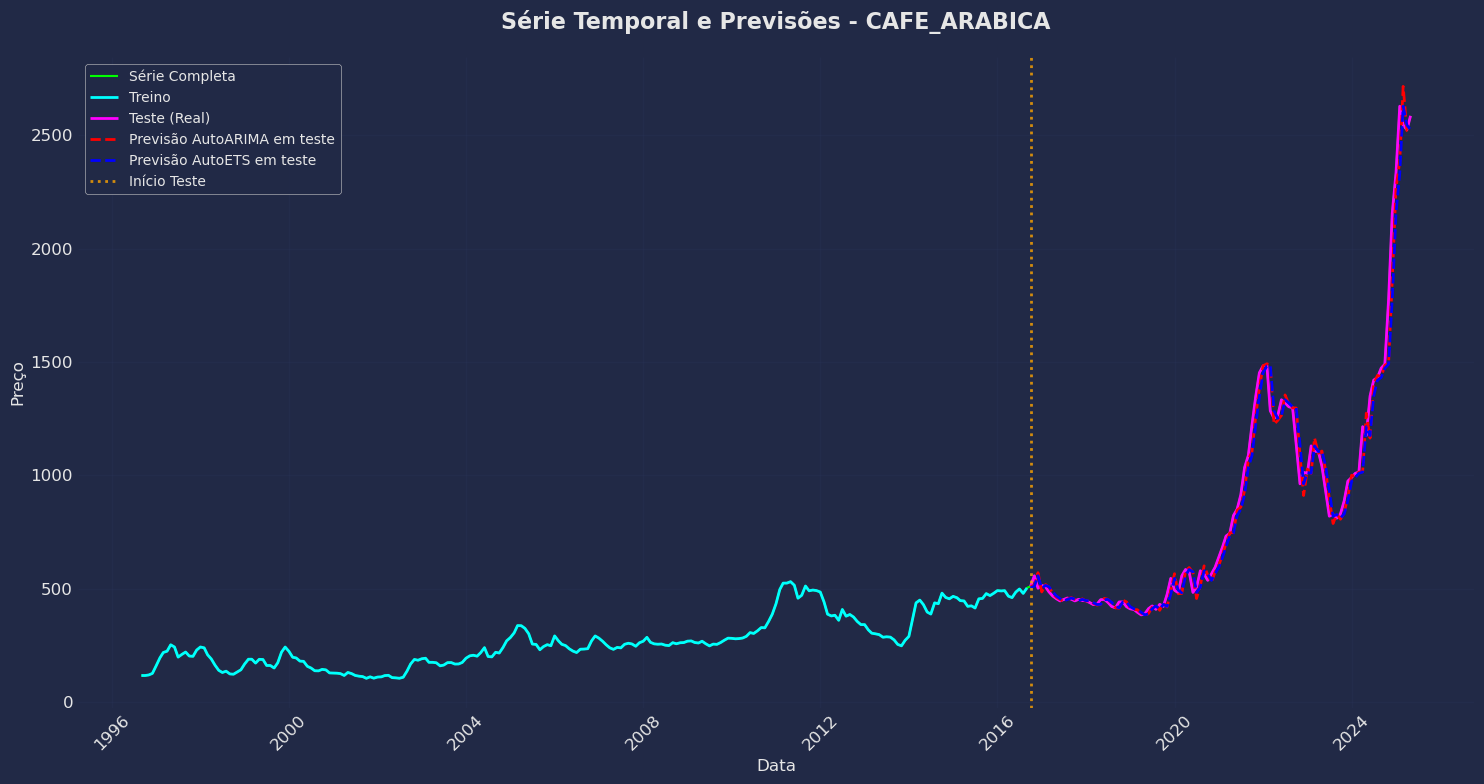

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------

=== Rodando Cross Validation para CAFE_ROBUSTA (Teste=87) ===
87


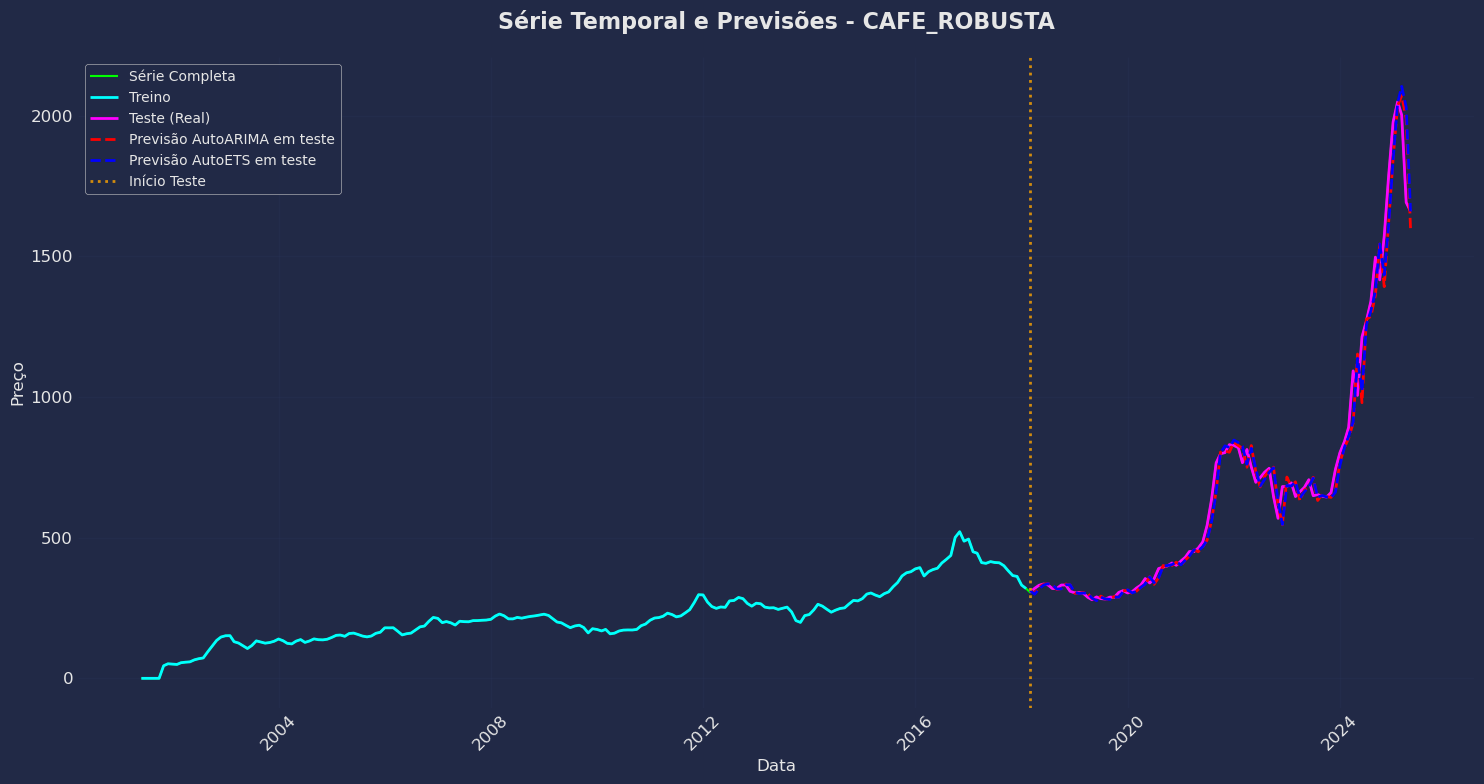

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------

=== Rodando Cross Validation para MILHO (Teste=75) ===
75


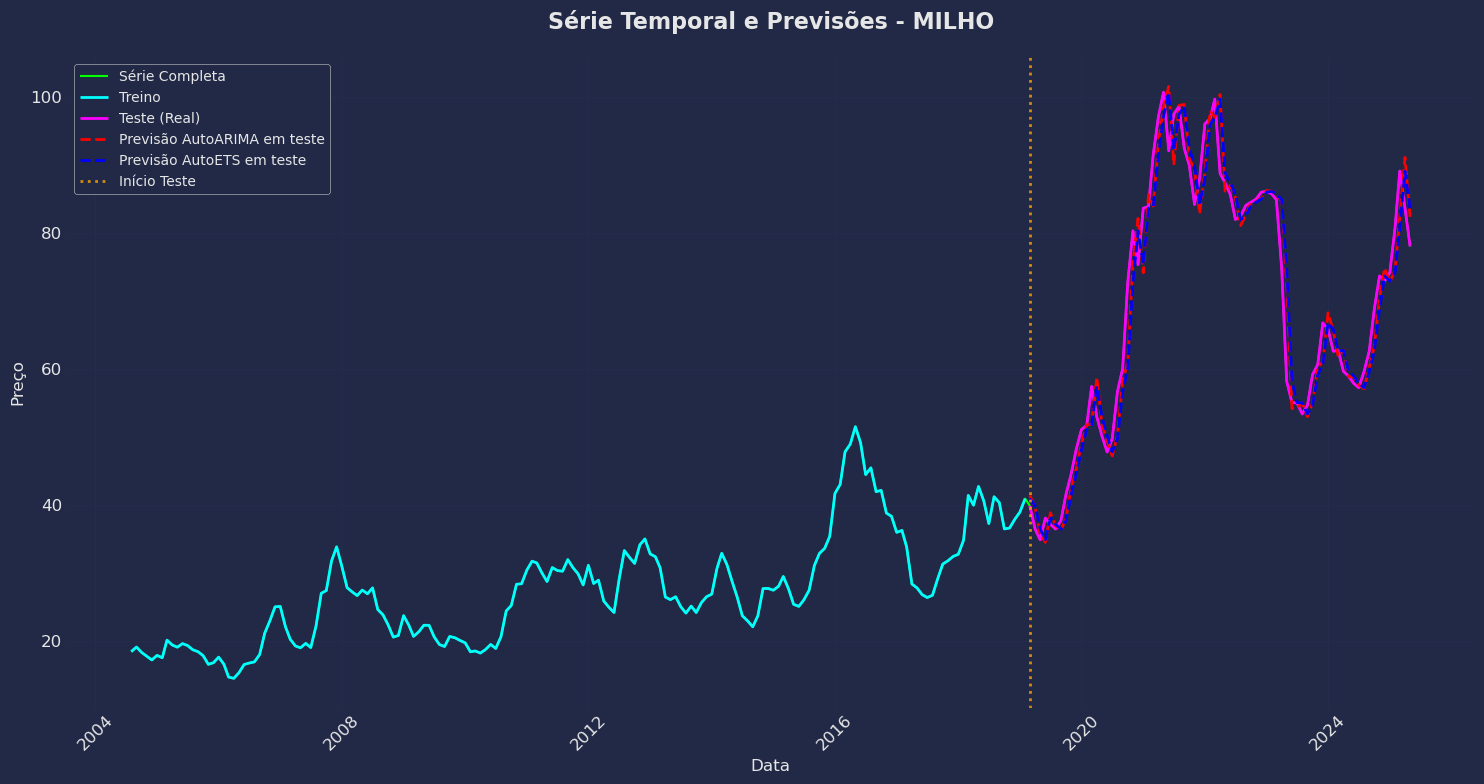

Gráfico exibido para: MILHO
--------------------------------------------------

=== Rodando Cross Validation para SOJA_PARANA (Teste=101) ===
101


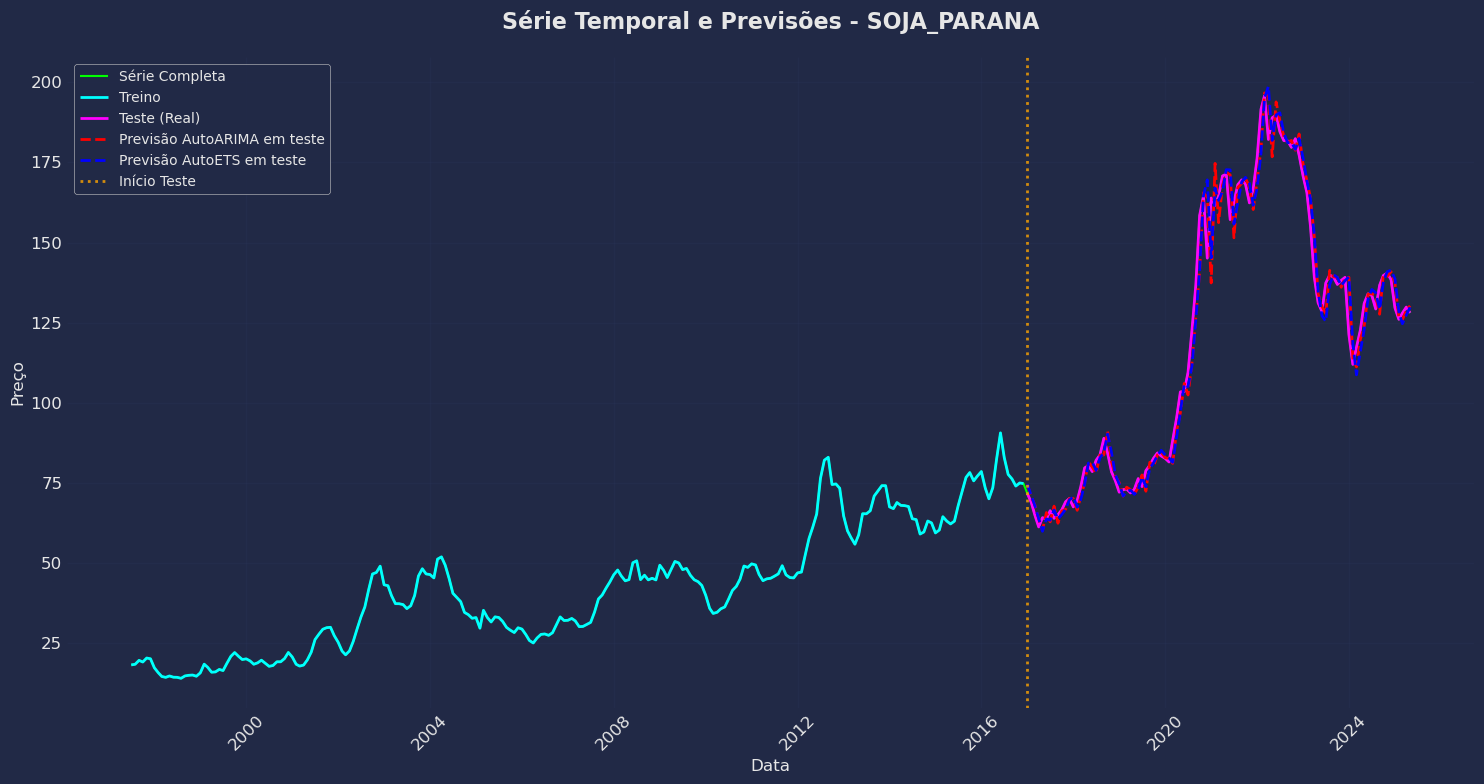

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------

=== Rodando Cross Validation para SOJA_PARANAGUA (Teste=70) ===
70


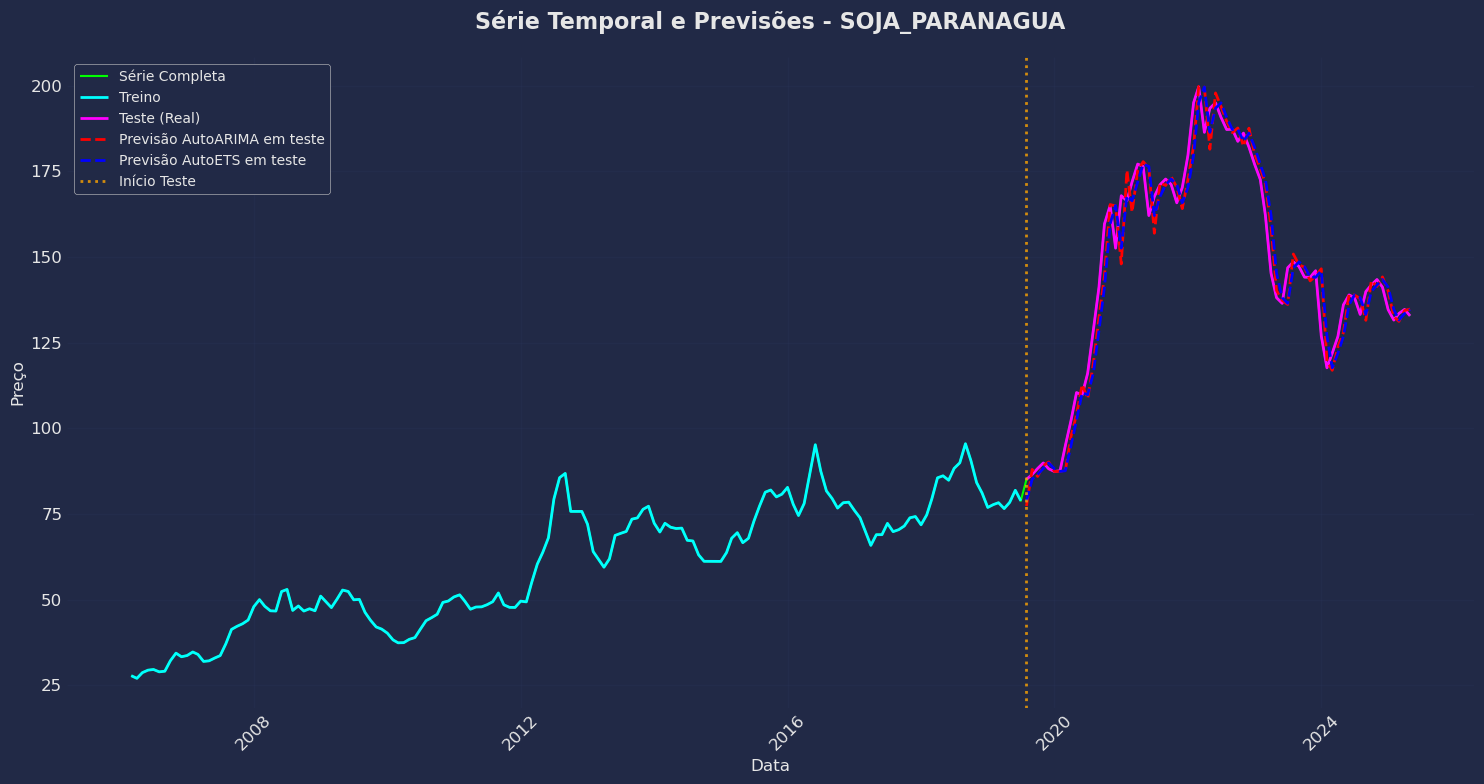

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------

=== Rodando Cross Validation para TRIGO_PARANA (Teste=77) ===
77


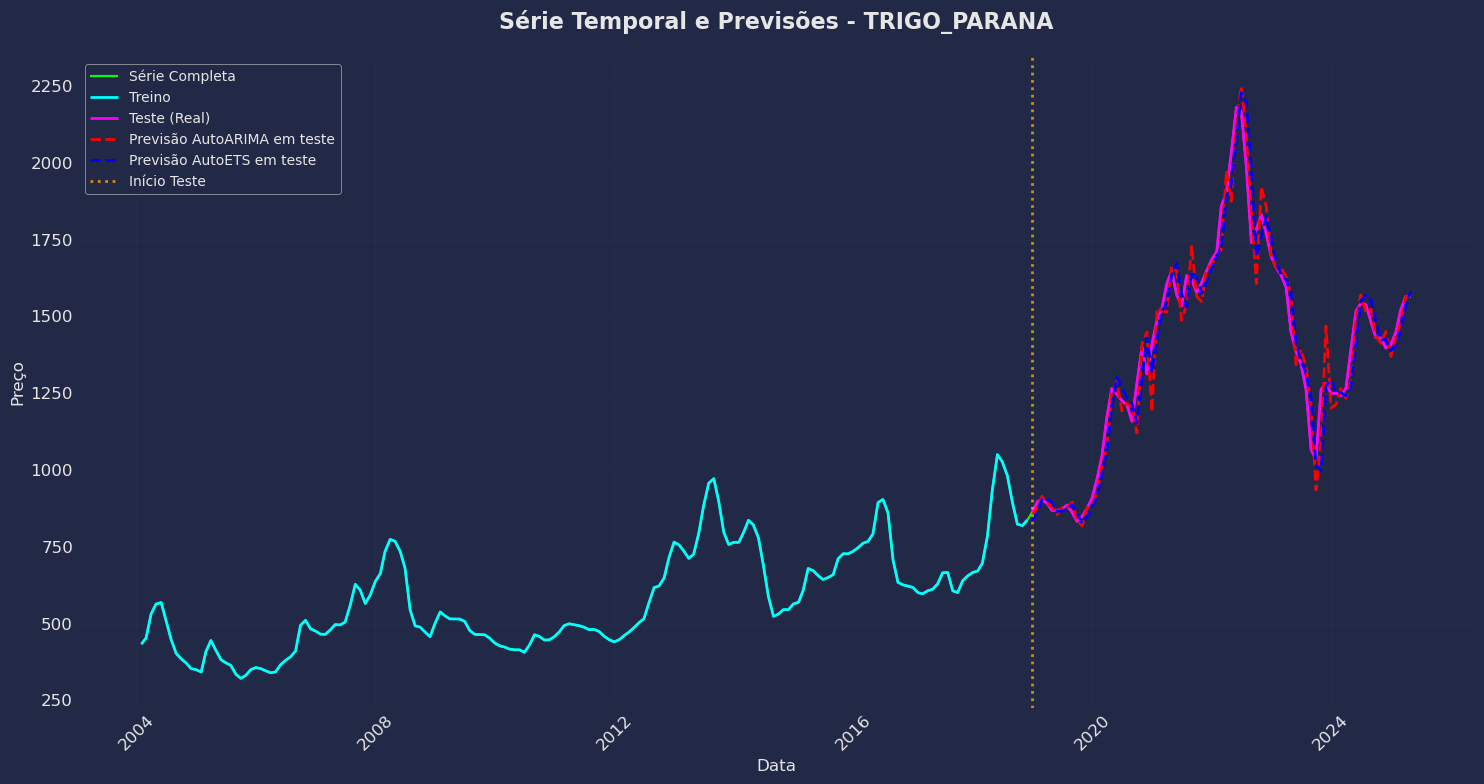

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------

=== Rodando Cross Validation para TRIGO_RS (Teste=77) ===
77


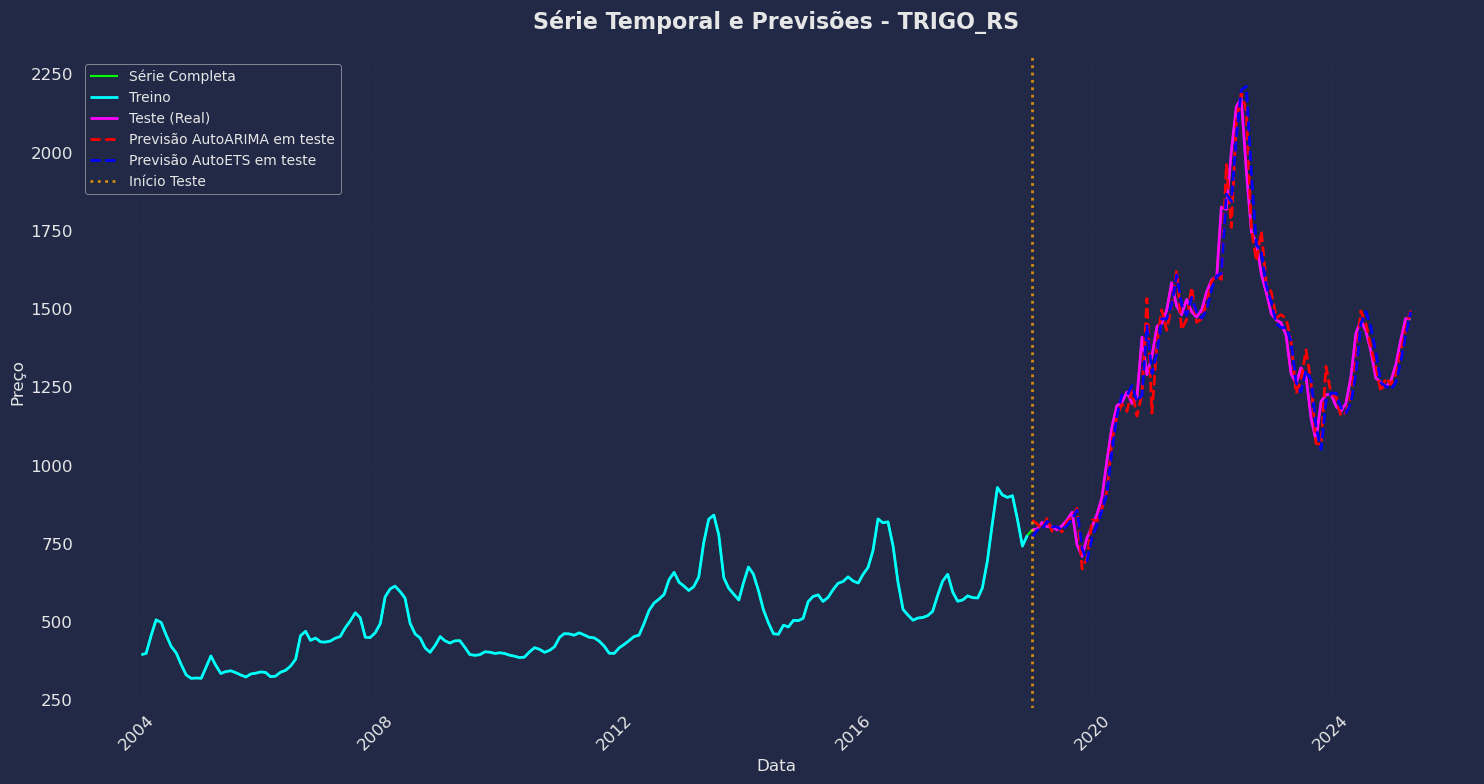

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [11]:
series_test_sizes = {
    "ACUCAR_SANTOS": 20,
    "ACUCAR_SP": 80,
    "ALGODAO": 105,
    "ARROZ": 72,
    "CAFE_ARABICA": 104,
    "CAFE_ROBUSTA": 87,
    "MILHO": 75,
    "SOJA_PARANA": 101,
    "SOJA_PARANAGUA": 70,
    "TRIGO_PARANA": 77,
    "TRIGO_RS": 77
}

results = {}

for uid, test_size in series_test_sizes.items():
    print(f"\n=== Rodando Cross Validation para {uid} (Teste={test_size}) ===")
    
    df = df_brl[df_brl['unique_id'] == uid]
    
    cv_df = sf.cross_validation(
        df=df,
        h=1,
        step_size=1,
        n_windows=test_size,
        fitted=True,
        refit=False
    )
    
    cv_fitted = sf.cross_validation_fitted_values()
    cv_fitted_clean = (
        cv_fitted.sort_values(["unique_id", "ds", "cutoff"])
                 .drop_duplicates(subset=["unique_id", "ds"], keep="last")
    )
    
    plot_single_series_and_forecasts(df, cv_df, test_size)
    
    results[uid] = {
        "cv_df": cv_df,
        "cv_fitted_clean": cv_fitted_clean
    }
